# Imports

In [65]:
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib.pyplot import subplots
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from ISLP.models import ModelSpec as MS

from sklearn.model_selection import (train_test_split,
                                     KFold,
                                     StratifiedKFold,
                                     LeaveOneOut,
                                     cross_val_score,
                                     validation_curve)
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             roc_auc_score,
                             roc_curve,
                             log_loss,
                             confusion_matrix,
                             ConfusionMatrixDisplay)
from sklearn.ensemble import \
     (BaggingClassifier as BC,
      RandomForestClassifier as RF,
      GradientBoostingClassifier as GBR)
from ISLP.bart import BART

# Plotting
import matplotlib.pyplot as plt

# Set a random seed for reproducibility
RNG_SEED = 111
np.random.seed(RNG_SEED)

# Extracting a pandas DataFrame from our CSV Data

In [66]:
Weather = pd.read_csv('balanced_set.csv')
Weather = Weather.assign(
    will_rain = pd.Categorical(
        ['No' if rain == 0 else 'Yes' for rain in Weather['rain']],
        categories=['No', 'Yes'])
    ).drop('rain', axis='columns').drop('precip', axis='columns'
    ).drop('DATE', axis='columns').dropna()
print(Weather.shape)

(1222, 5)


# Simple Exploratory Data Analysis

In [67]:
Weather.describe().T

count       mean        std    min    25%    50%    75%    max
humidity      1222.0  69.789689  10.971520  23.00  65.00  72.00  77.00  95.00
wind_speed    1222.0   6.052455   2.473229   1.80   4.50   5.80   7.00  21.60
sea_pressure  1222.0  29.995360   0.102928  29.57  29.93  29.99  30.06  30.29
min_temp      1222.0  57.964812   7.290817  38.00  53.00  58.00  63.00  78.00

In [68]:
will_rain = Weather['will_rain'] == 'Yes'
yes_rain_data = Weather[will_rain]
no_rain_data = Weather[~will_rain]

yes_rain_data.describe().T

count       mean       std    min    25%    50%    75%    max
humidity      611.0  72.006547  8.841962  30.00  67.00  73.00  78.00  95.00
wind_speed    611.0   7.020949  2.783002   1.90   5.20   6.50   8.40  21.60
sea_pressure  611.0  29.993568  0.105858  29.57  29.93  29.99  30.07  30.28
min_temp      611.0  56.729951  6.086594  38.00  53.00  56.00  60.00  78.00

In [69]:
no_rain_data.describe().T

count       mean        std    min    25%    50%    75%    max
humidity      611.0  67.572831  12.366103  23.00  64.00  71.00  76.00  87.00
wind_speed    611.0   5.083961   1.618521   1.80   3.90   5.10   6.10  10.90
sea_pressure  611.0  29.997152   0.099968  29.75  29.93  29.98  30.06  30.29
min_temp      611.0  59.199673   8.142344  38.00  54.00  61.00  66.00  74.00

# Building a Simple Decision Tree Model

In [70]:
X = Weather.drop('will_rain', axis='columns')
y = Weather['will_rain']
print(X.dtypes)

# Training/Test Split
(X_train_df,
 X_test,
 y_train,
 y_test) = train_test_split(X, y, test_size=0.2, random_state=RNG_SEED)

X_test = np.asarray(X_test)

model = MS(X_train_df, intercept=False)
D = model.fit_transform(X_train_df, y_train)
predictors = list(D.columns)
clf_test = DTC(criterion='gini',
               max_depth=3,
               random_state=RNG_SEED)
X_train = np.asarray(D)
clf_test.fit(X_train, y_train)

humidity        float64
wind_speed      float64
sea_pressure    float64
min_temp        float64
dtype: object


DecisionTreeClassifier(max_depth=3, random_state=111)

# Trying out a Decision Tree built from the full training set

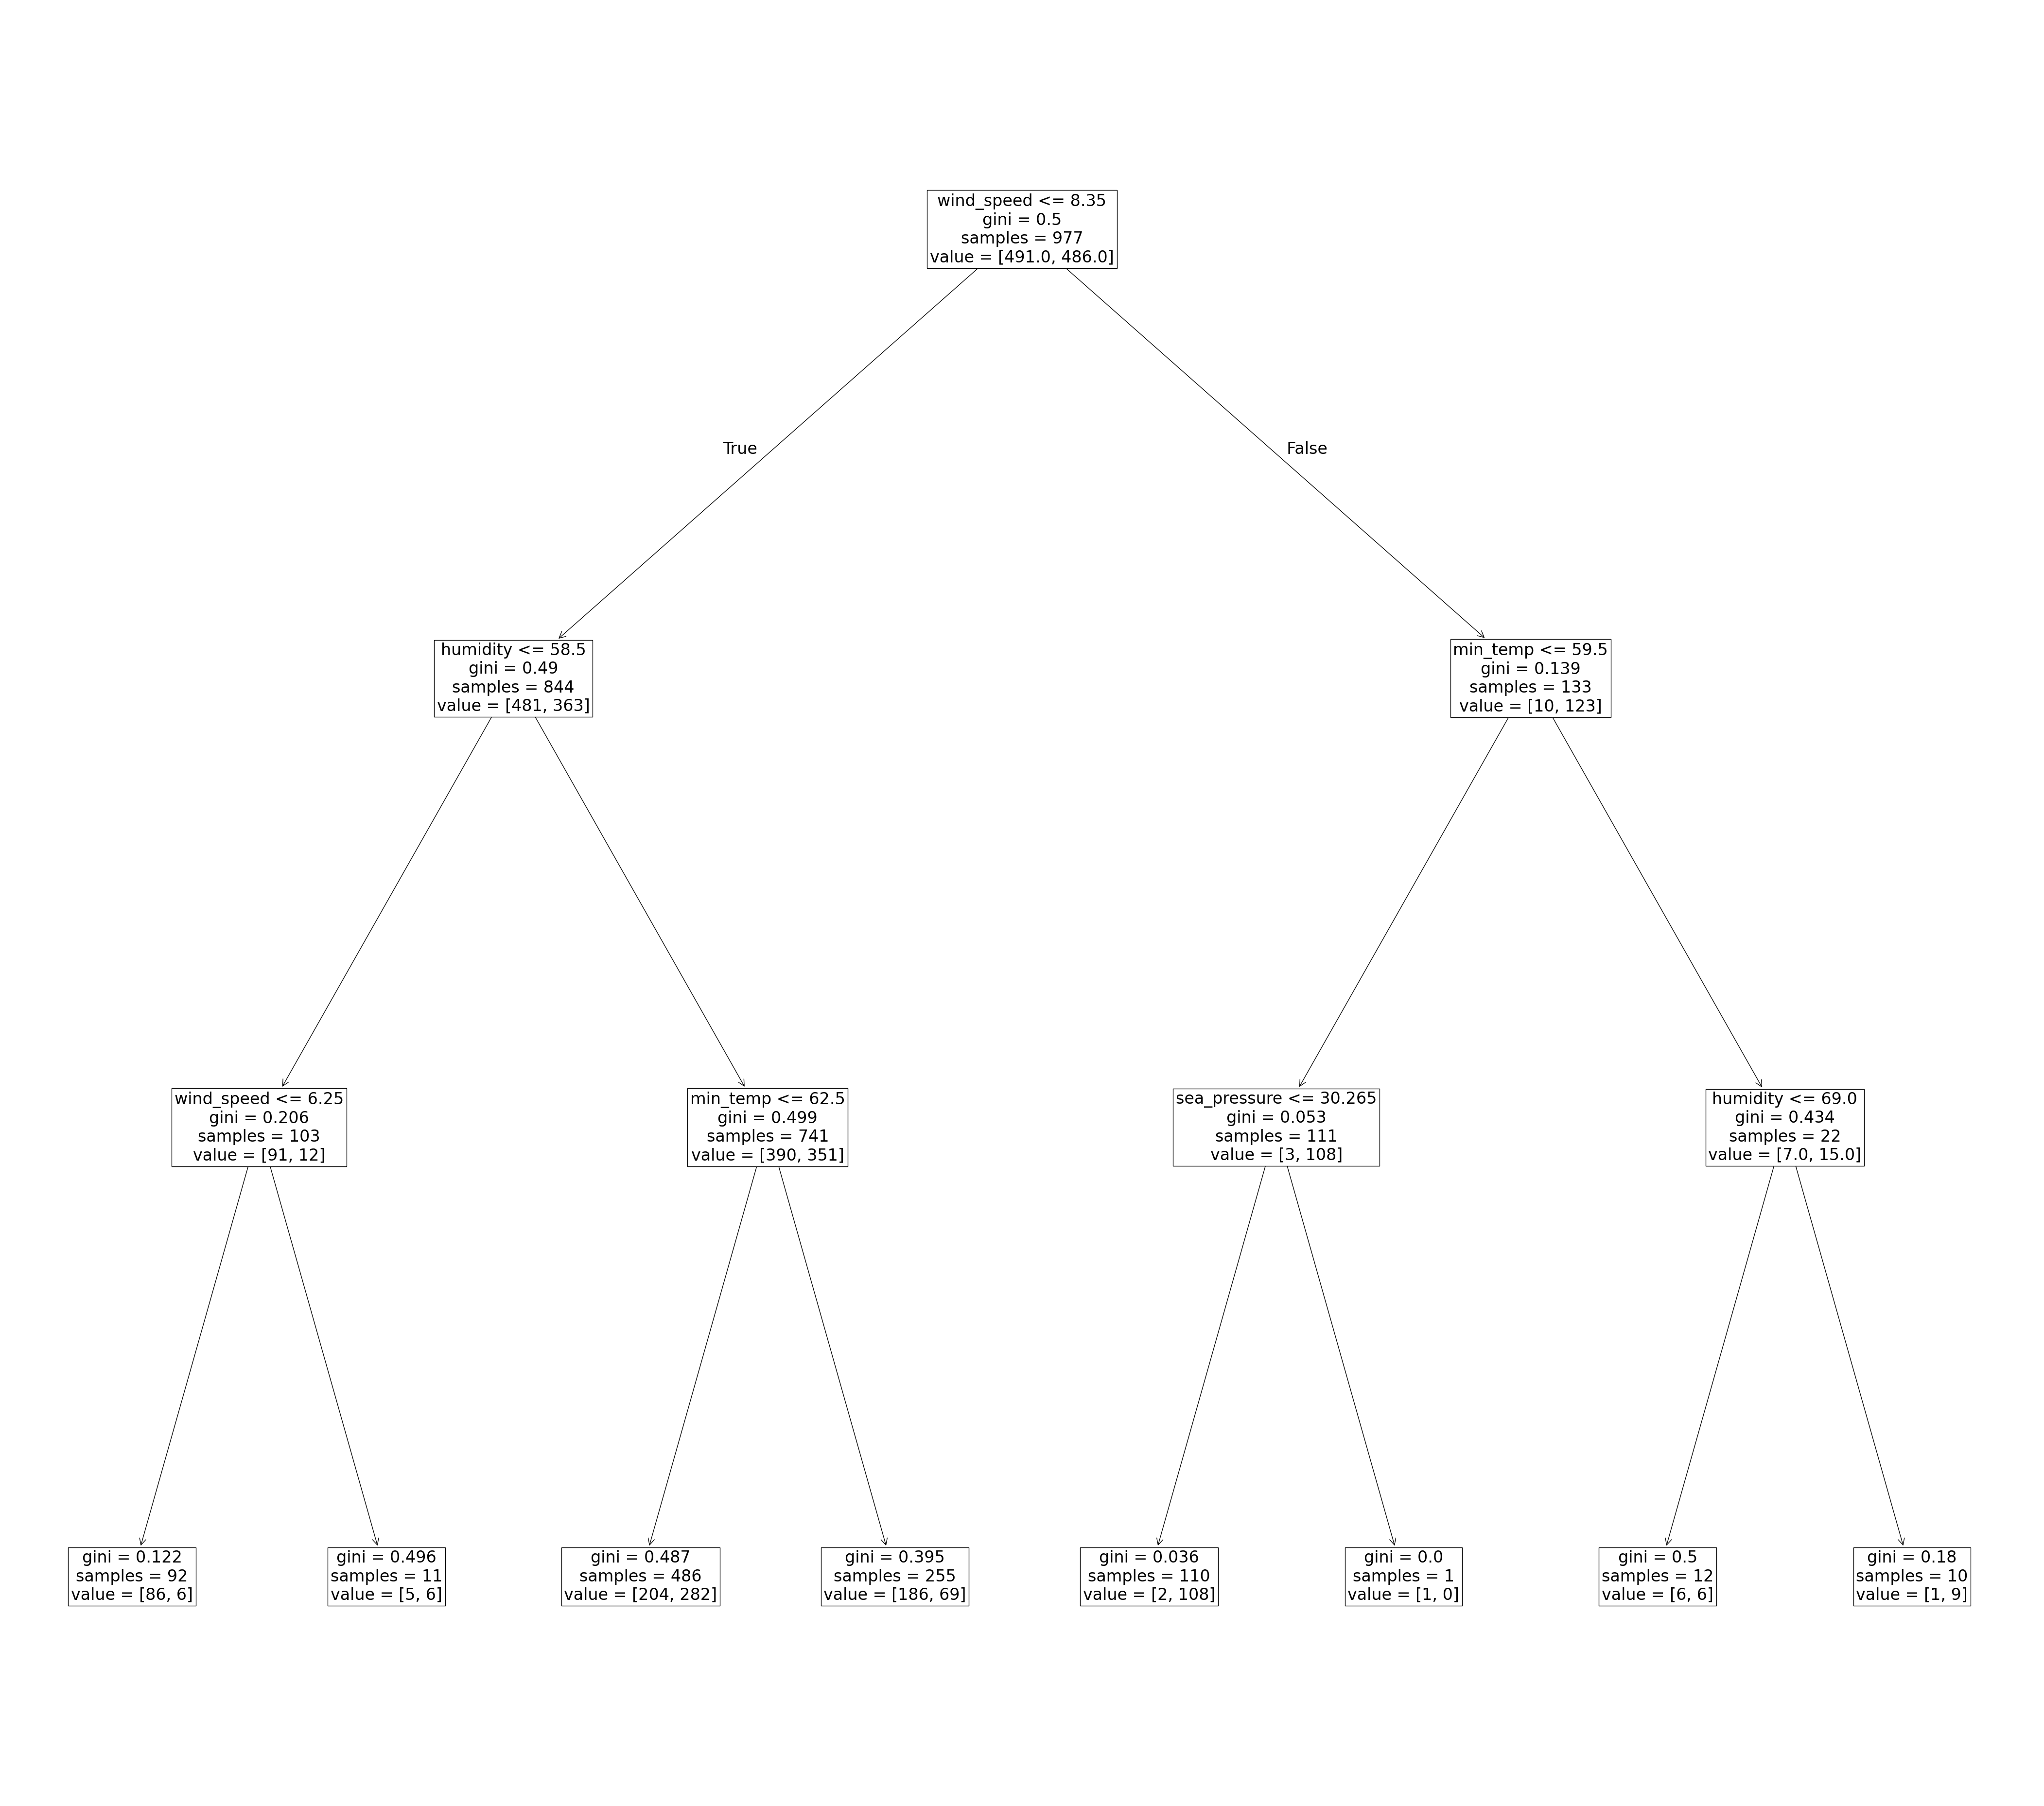

In [71]:
fig, ax = subplots(figsize=(54,48))
plot_tree(clf_test,
          feature_names=predictors,
          fontsize=24,
          ax=ax)
fig.savefig('fig1.png')

# Using pruning and cross-validation to select optimal tree parameters

Unpruned Model Training Error: 0.0
Naive Bayes Training Error: 0.4980793854033291
Unpruned Model Test Error: 0.326530612244898
Naive Bayes Test Error: 0.47959183673469385


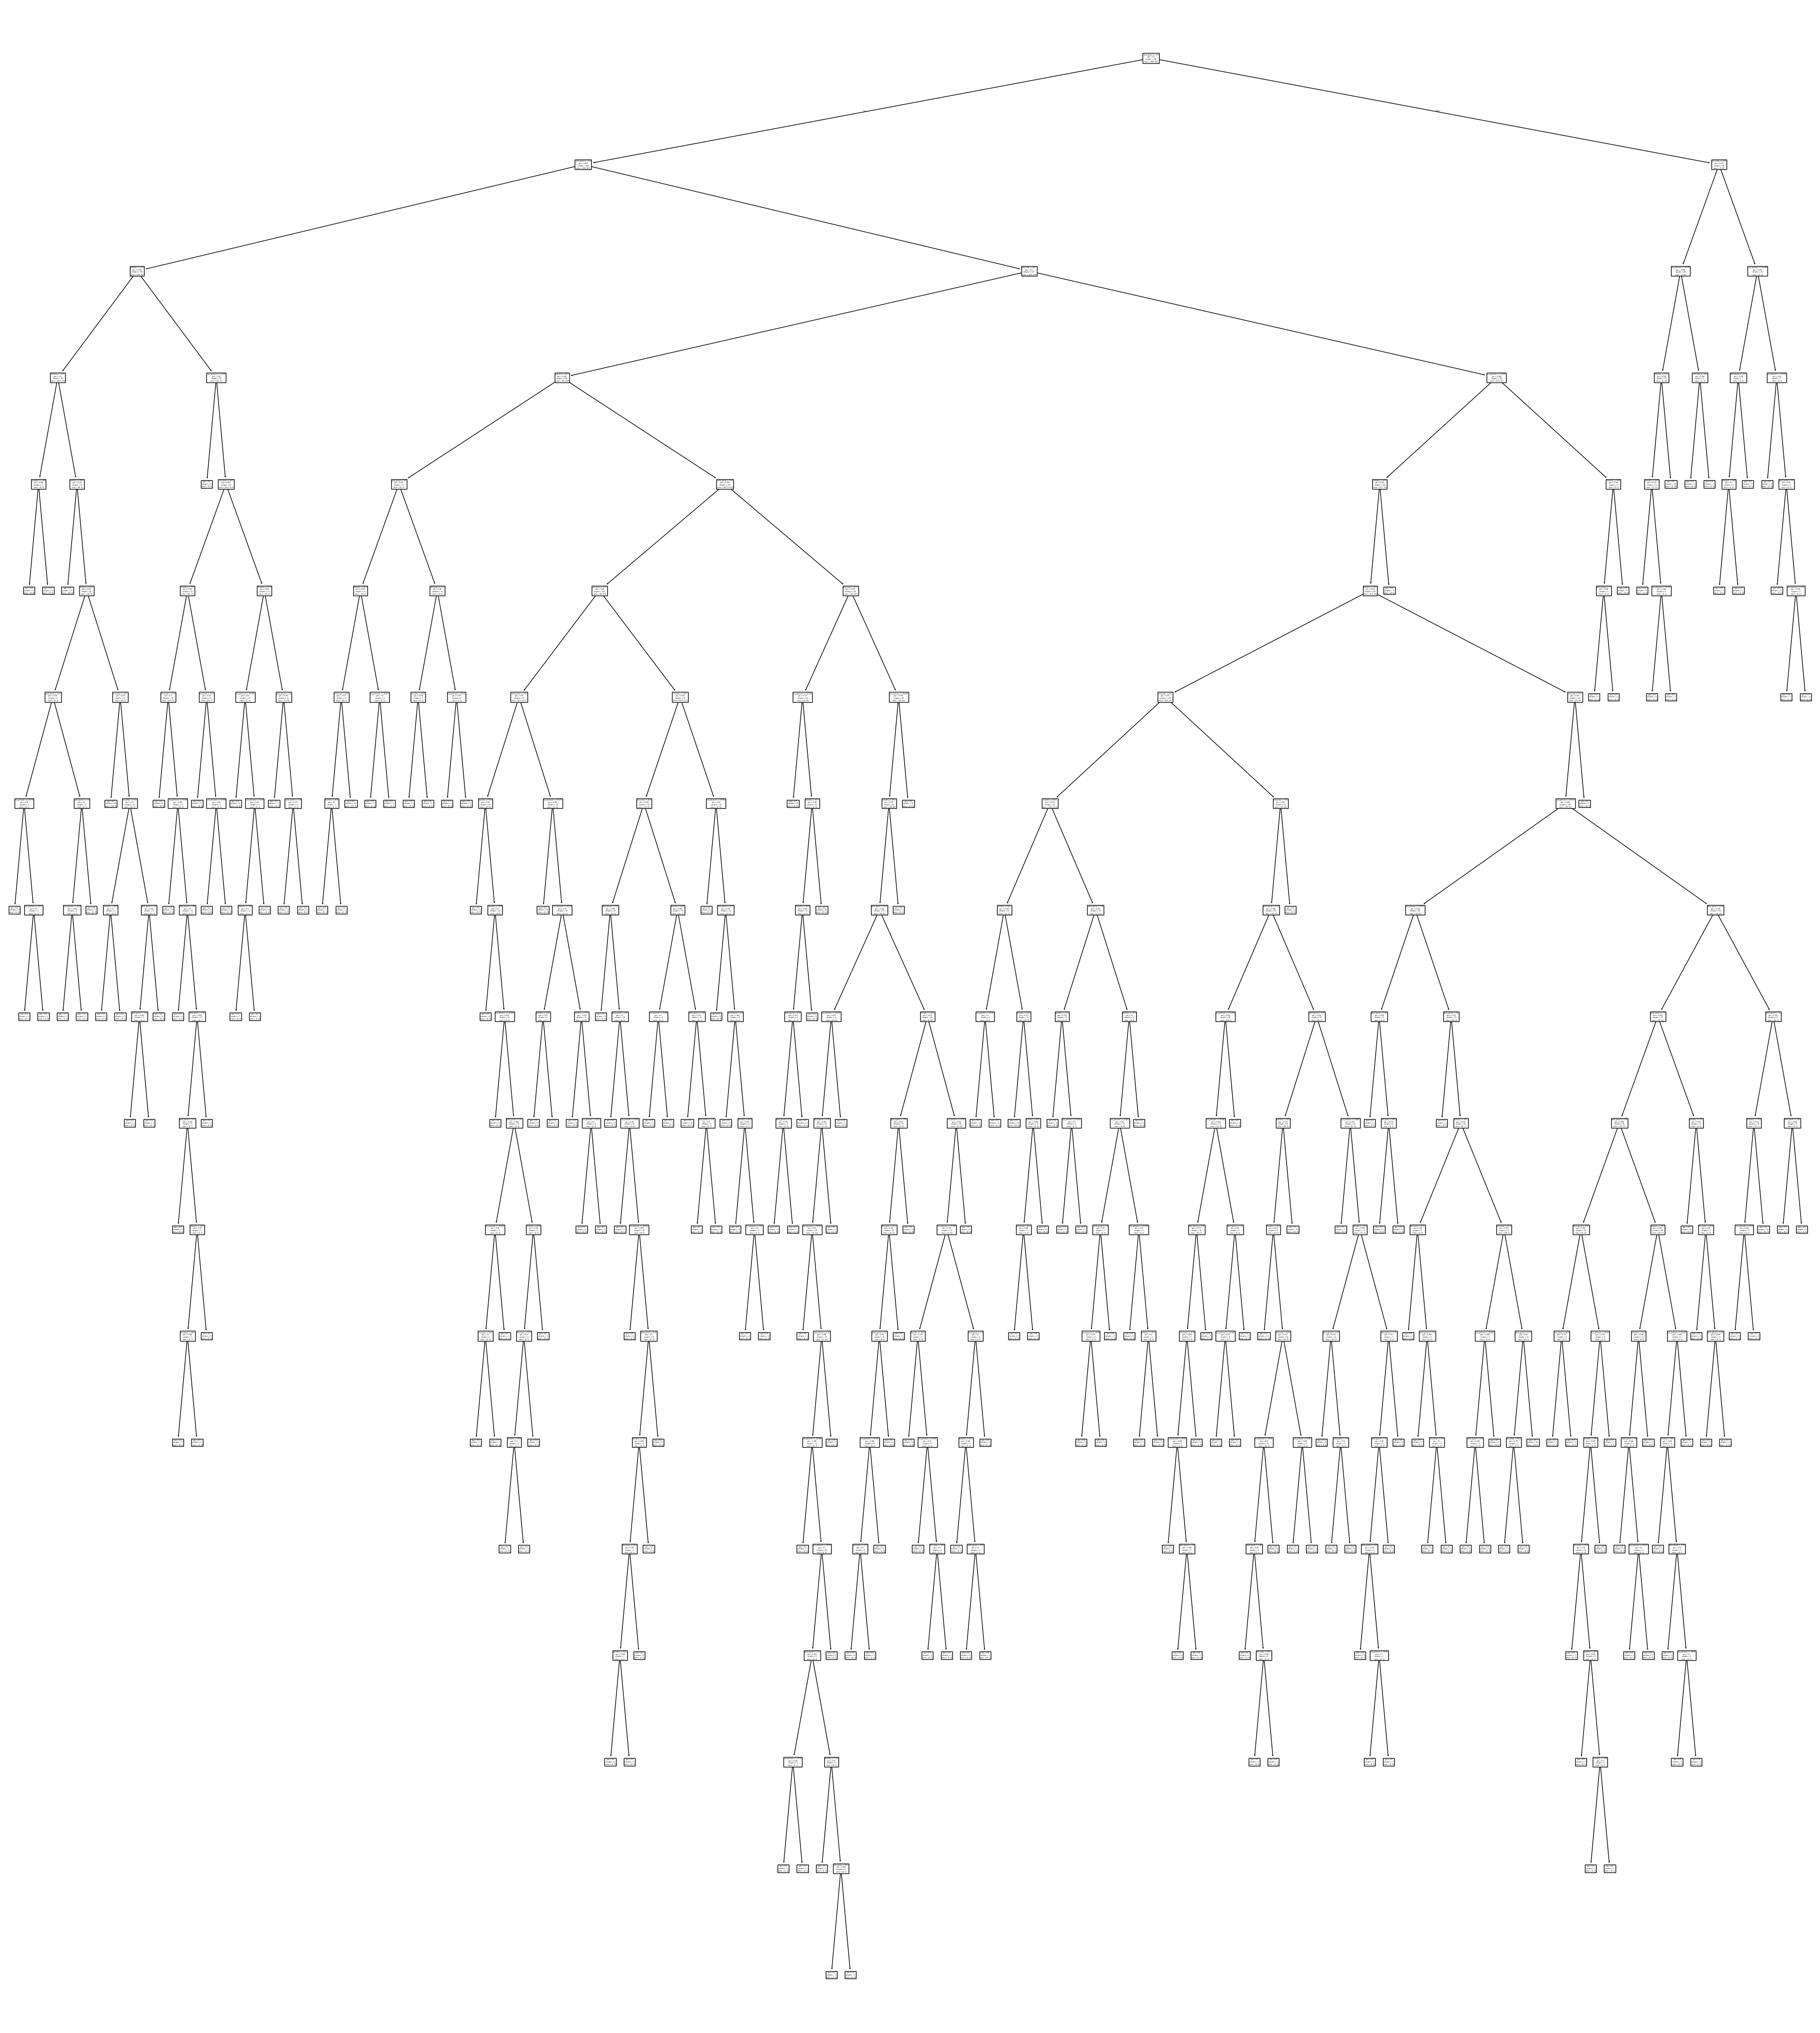

In [72]:
# Further training/test split to avoid using the held-out test set
(X_train_s,
 X_test_s,
 y_train_s,
 y_test_s) = train_test_split(X_train, y_train, test_size=0.2, random_state=RNG_SEED+1)

clf_s = DTC(criterion='gini', random_state=RNG_SEED)
clf_s.fit(X_train_s, y_train_s)

# Plot the unpruned tree
fig, ax = subplots(figsize=(48,54))
plot_tree(clf_s,
          feature_names=predictors,
          ax=ax);

fig.savefig("fig6.png")

err_unp_train_s = 1 - accuracy_score(y_train_s, clf_s.predict(X_train_s))
err_bayes_train_s = 1 - accuracy_score(y_train_s, ['Yes'] * len(y_train_s))
err_unp_test_s = 1 - accuracy_score(y_test_s, clf_s.predict(X_test_s))
err_bayes_test_s = 1 - accuracy_score(y_test_s, ['No'] * len(y_test_s))

print("Unpruned Model Training Error: " + str(err_unp_train_s))
print("Naive Bayes Training Error: " + str(err_bayes_train_s))

print("Unpruned Model Test Error: " + str(err_unp_test_s))
print("Naive Bayes Test Error: " + str(err_bayes_test_s))

In [73]:
ccp_path_s = clf_s.cost_complexity_pruning_path(X_train_s, y_train_s)
kfold = skm.KFold(10,
                  random_state=RNG_SEED,
                  shuffle=True)
grid_ccp_s = skm.GridSearchCV(clf_s,
                              {'ccp_alpha': ccp_path_s.ccp_alphas},
                              refit=True,
                              cv=kfold,
                              scoring='accuracy')
grid_ccp_s.fit(X_train_s, y_train_s)

GridSearchCV(cv=KFold(n_splits=10, random_state=111, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=111),
             param_grid={'ccp_alpha': array([0.        , 0.00075876, 0.00076825, 0.00083863, 0.00084307,
       0.00085361, 0.00085361, 0.00085361, 0.00096031, 0.00102433,
       0.00102433, 0.00102433, 0.00102433, 0.00102433, 0.00102433,
       0.00102433, 0.00106701, 0.00106701, 0.00109749, 0....
       0.00208739, 0.00211268, 0.00213402, 0.00213402, 0.00216685,
       0.00218702, 0.00222566, 0.00224161, 0.00225955, 0.00227628,
       0.00231253, 0.00236625, 0.00241756, 0.00246936, 0.00258242,
       0.00263457, 0.0027666 , 0.00315537, 0.00321281, 0.00341443,
       0.00344894, 0.00362527, 0.00363794, 0.00369097, 0.00474382,
       0.00625771, 0.00815356, 0.01139092, 0.01356873, 0.03390811,
       0.05223728])},
             scoring='accuracy')

In [74]:
ccp_cv = 1 - grid_ccp_s.best_score_

print("Best CV Error:", ccp_cv)

Best CV Error: 0.2855079519636481


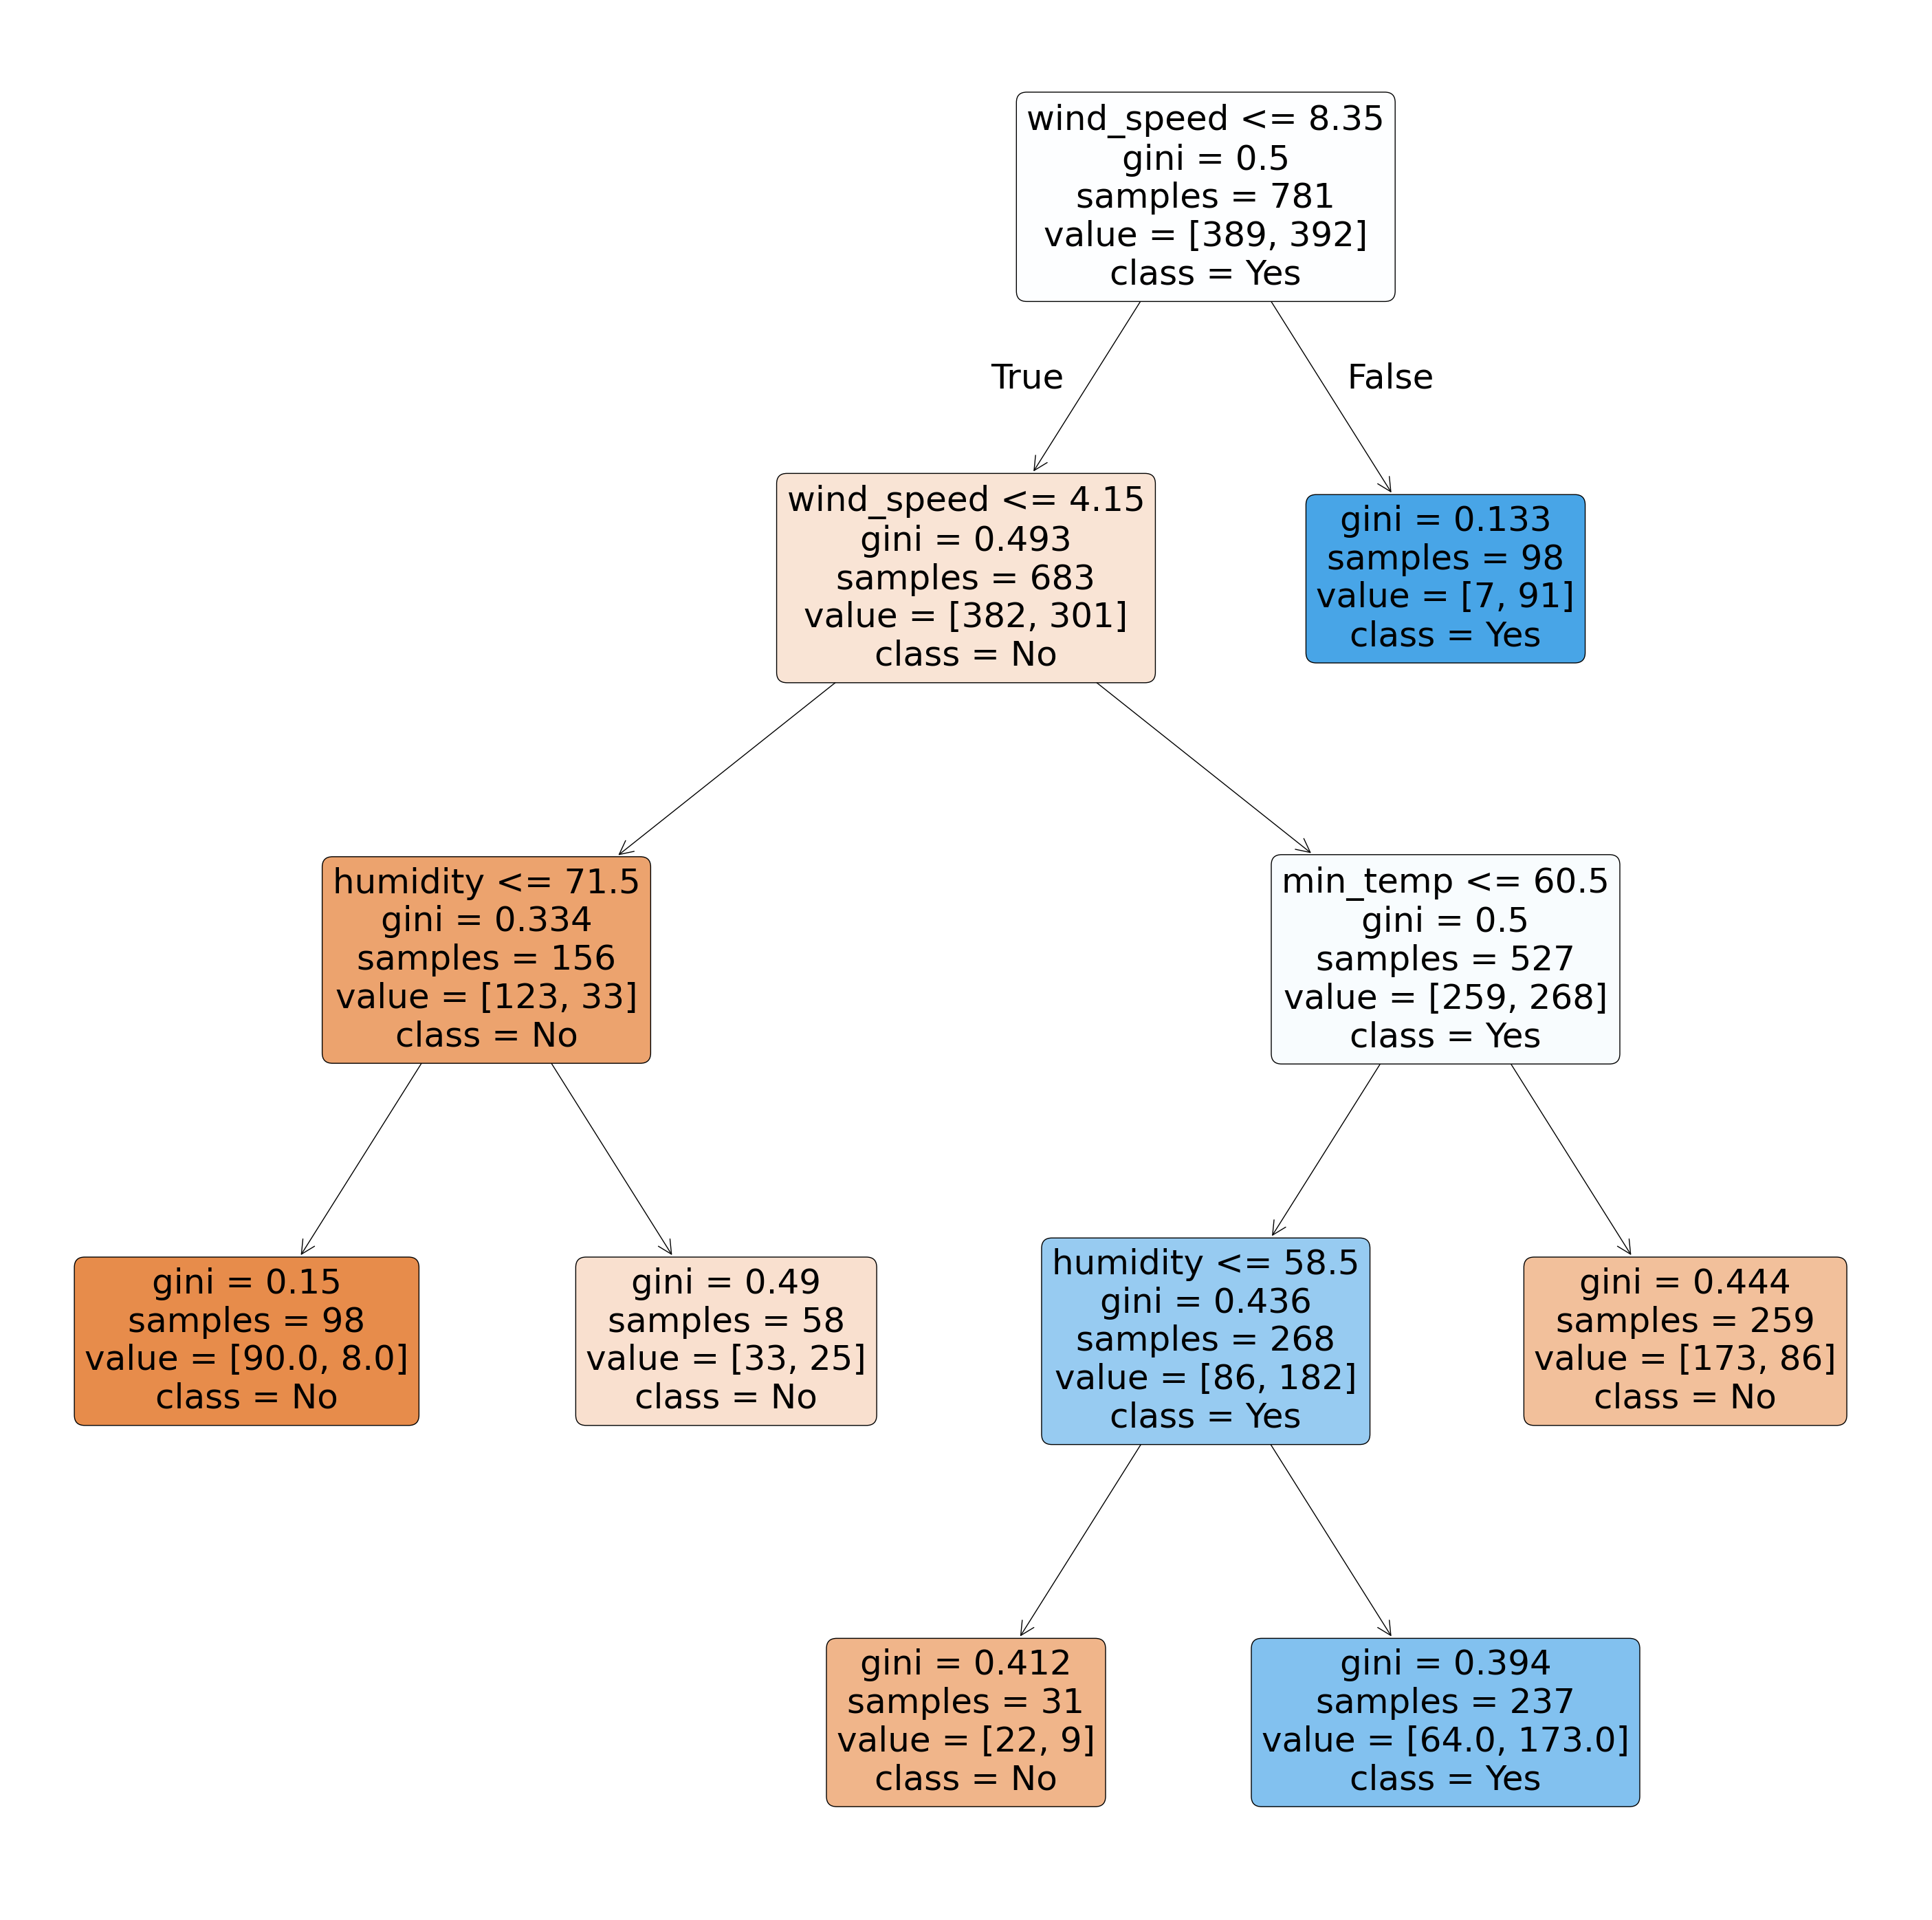

In [75]:
fig, ax = subplots(figsize=(36,36))
best_ccp_s = grid_ccp_s.best_estimator_
plot_tree(best_ccp_s,
          feature_names=predictors,
          ax=ax,
          class_names=['No', 'Yes'],
          rounded=True,
          filled=True,
         fontsize=36);
fig.savefig("fig4.png")

In [76]:
err_ccp_train_s = 1 - accuracy_score(y_train_s, best_ccp_s.predict(X_train_s))
err_ccp_test_s = 1 - accuracy_score(y_test_s, best_ccp_s.predict(X_test_s))

print("Model Training Error: " + str(err_ccp_train_s))
print("Naive Bayes Training Error: " + str(err_bayes_train_s))

print("Model Test Error: " + str(err_ccp_test_s))
print("Naive Bayes Test Error: " + str(err_bayes_test_s))
confusion_ccp_s = confusion_matrix(best_ccp_s.predict(X_test_s),
                                   y_test_s)


confusion_ccp_s

Model Training Error: 0.25480153649167736
Naive Bayes Training Error: 0.4980793854033291
Model Test Error: 0.2551020408163265
Naive Bayes Test Error: 0.47959183673469385


array([[78, 26],
       [24, 68]])

# Making a graph of alpha value vs. CV error

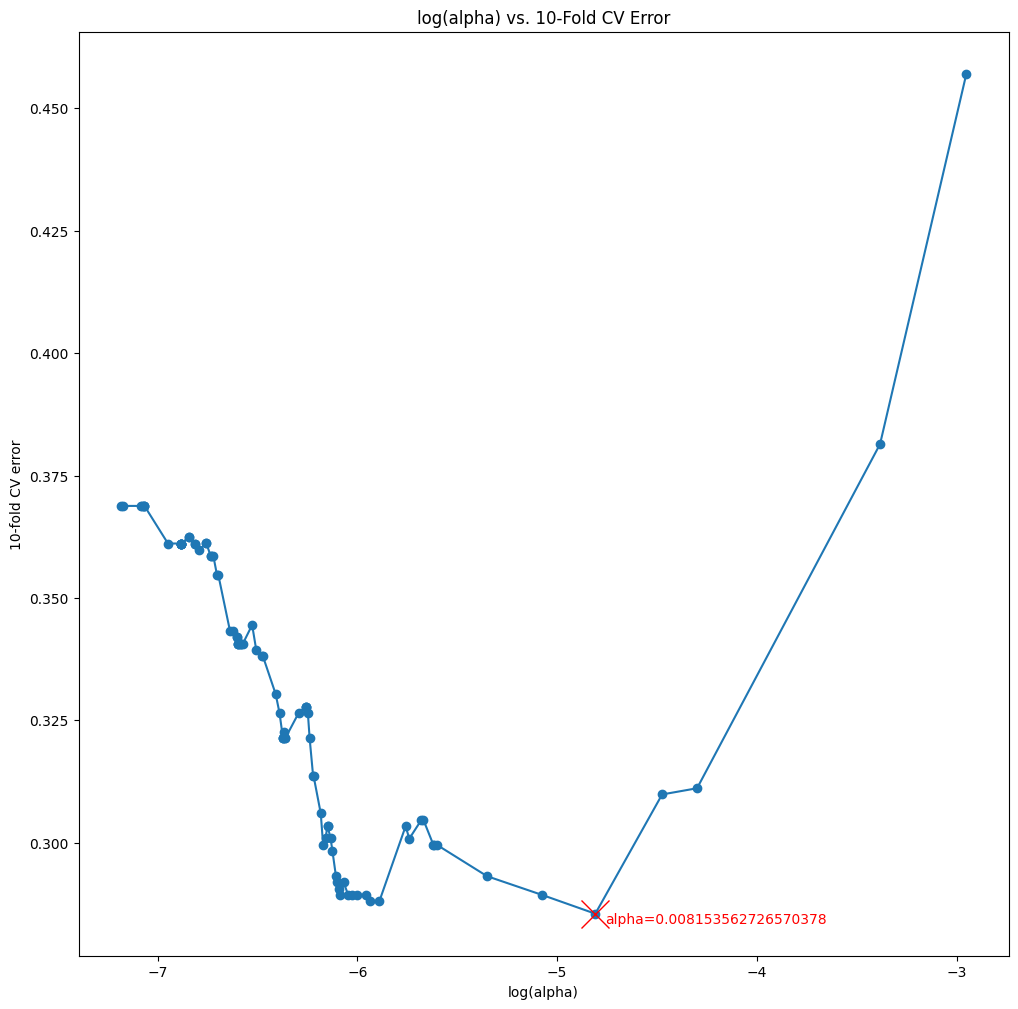

In [77]:
cv_df_ccp_s = pd.DataFrame(grid_ccp_s.cv_results_)
alpha_list_s = np.log([alpha_dict['ccp_alpha'] for alpha_dict in cv_df_ccp_s['params'][1::]])
err_list_s = [1 - acc for acc in cv_df_ccp_s['mean_test_score'][1::]]
min_err_s = min(err_list_s)
min_ind_s = err_list_s.index(min_err_s)
best_alpha_s = alpha_list_s[min_ind_s]

plt.figure(figsize=(12,12))

plt.plot(alpha_list_s, err_list_s, marker='o')
plt.plot(best_alpha_s, min_err_s, marker='x', markersize=20, color='red')
plt.text(best_alpha_s+0.05, min_err_s - 0.002, "alpha=" + str(np.exp(best_alpha_s)), fontsize=10, color='red')
plt.xlabel("log(alpha)"); plt.ylabel("10-fold CV error"); plt.title("log(alpha) vs. 10-Fold CV Error")
plt.savefig("fig2.png");
plt.show();




# Plotting Baseline/Model Training/Test Error

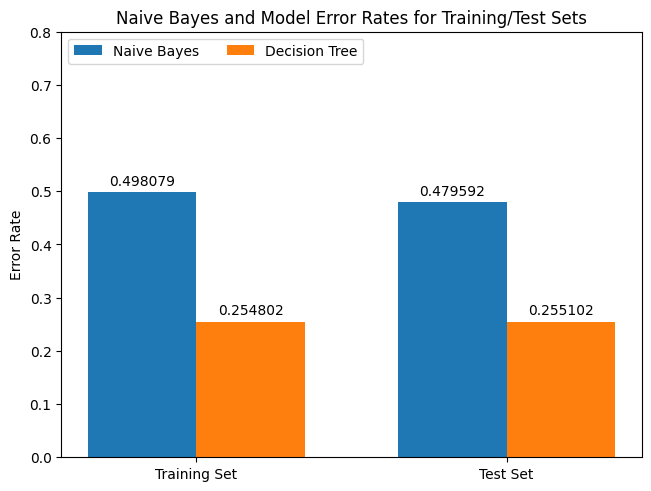

In [78]:
error_sets_ccp_s = ("Training Set", "Test Set")
errors_ccp_s = {
    'Naive Bayes': (err_bayes_train_s, err_bayes_test_s),
    'Decision Tree': (err_ccp_train_s, err_ccp_test_s)
}

x = np.arange(len(error_sets_ccp_s))
width = 0.35
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in errors_ccp_s.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Error Rate')
ax.set_title('Naive Bayes and Model Error Rates for Training/Test Sets')
ax.set_xticks(x + width/2, error_sets_ccp_s)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 0.8)
fig.savefig("fig5.png")

plt.show()

# ROC-AUC

Test ROC-AUC: 0.7906758448060075


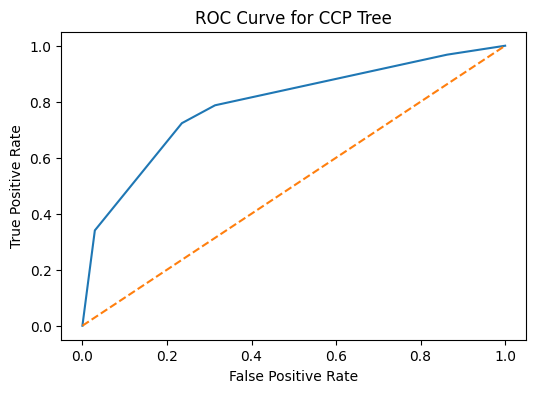

array([0.33204633, 0.72995781, 0.92857143, 0.43103448, 0.72995781,
       0.33204633, 0.33204633, 0.43103448, 0.92857143, 0.72995781,
       0.72995781, 0.92857143, 0.43103448, 0.72995781, 0.33204633,
       0.33204633, 0.92857143, 0.72995781, 0.72995781, 0.33204633,
       0.43103448, 0.92857143, 0.72995781, 0.72995781, 0.33204633,
       0.72995781, 0.33204633, 0.72995781, 0.72995781, 0.33204633,
       0.92857143, 0.33204633, 0.33204633, 0.43103448, 0.33204633,
       0.72995781, 0.08163265, 0.92857143, 0.92857143, 0.72995781,
       0.33204633, 0.43103448, 0.33204633, 0.43103448, 0.92857143,
       0.92857143, 0.92857143, 0.43103448, 0.33204633, 0.33204633,
       0.33204633, 0.33204633, 0.72995781, 0.33204633, 0.72995781,
       0.33204633, 0.33204633, 0.72995781, 0.92857143, 0.33204633,
       0.33204633, 0.33204633, 0.08163265, 0.43103448, 0.08163265,
       0.72995781, 0.72995781, 0.72995781, 0.92857143, 0.92857143,
       0.33204633, 0.92857143, 0.72995781, 0.72995781, 0.92857

In [79]:
prob_test_ccp_s = best_ccp_s.predict_proba(X_test_s)[:,1]
auc_ccp = roc_auc_score(y_test_s, prob_test_ccp_s)

print("Test ROC-AUC: " + str(roc_auc_score(y_test_s, prob_test_ccp_s)))

fpr_ccp, tpr_ccp = roc_curve(y_test_s, prob_test_ccp_s,
                             pos_label="Yes")[:2]
fig, ax = subplots(figsize=(6,4))
ax.plot(fpr_ccp, tpr_ccp)
ax.plot([0,1], [0,1], linestyle='--')
ax.set_ylabel("True Positive Rate")
ax.set_xlabel("False Positive Rate")
ax.set_title("ROC Curve for CCP Tree")
fig.savefig("fig9.png")

plt.show()

prob_test_ccp_s

# Fitting the full model on the entire training set

Unpruned Model Training Error: 0.0
Naive Bayes Training Error: 0.4974411463664279


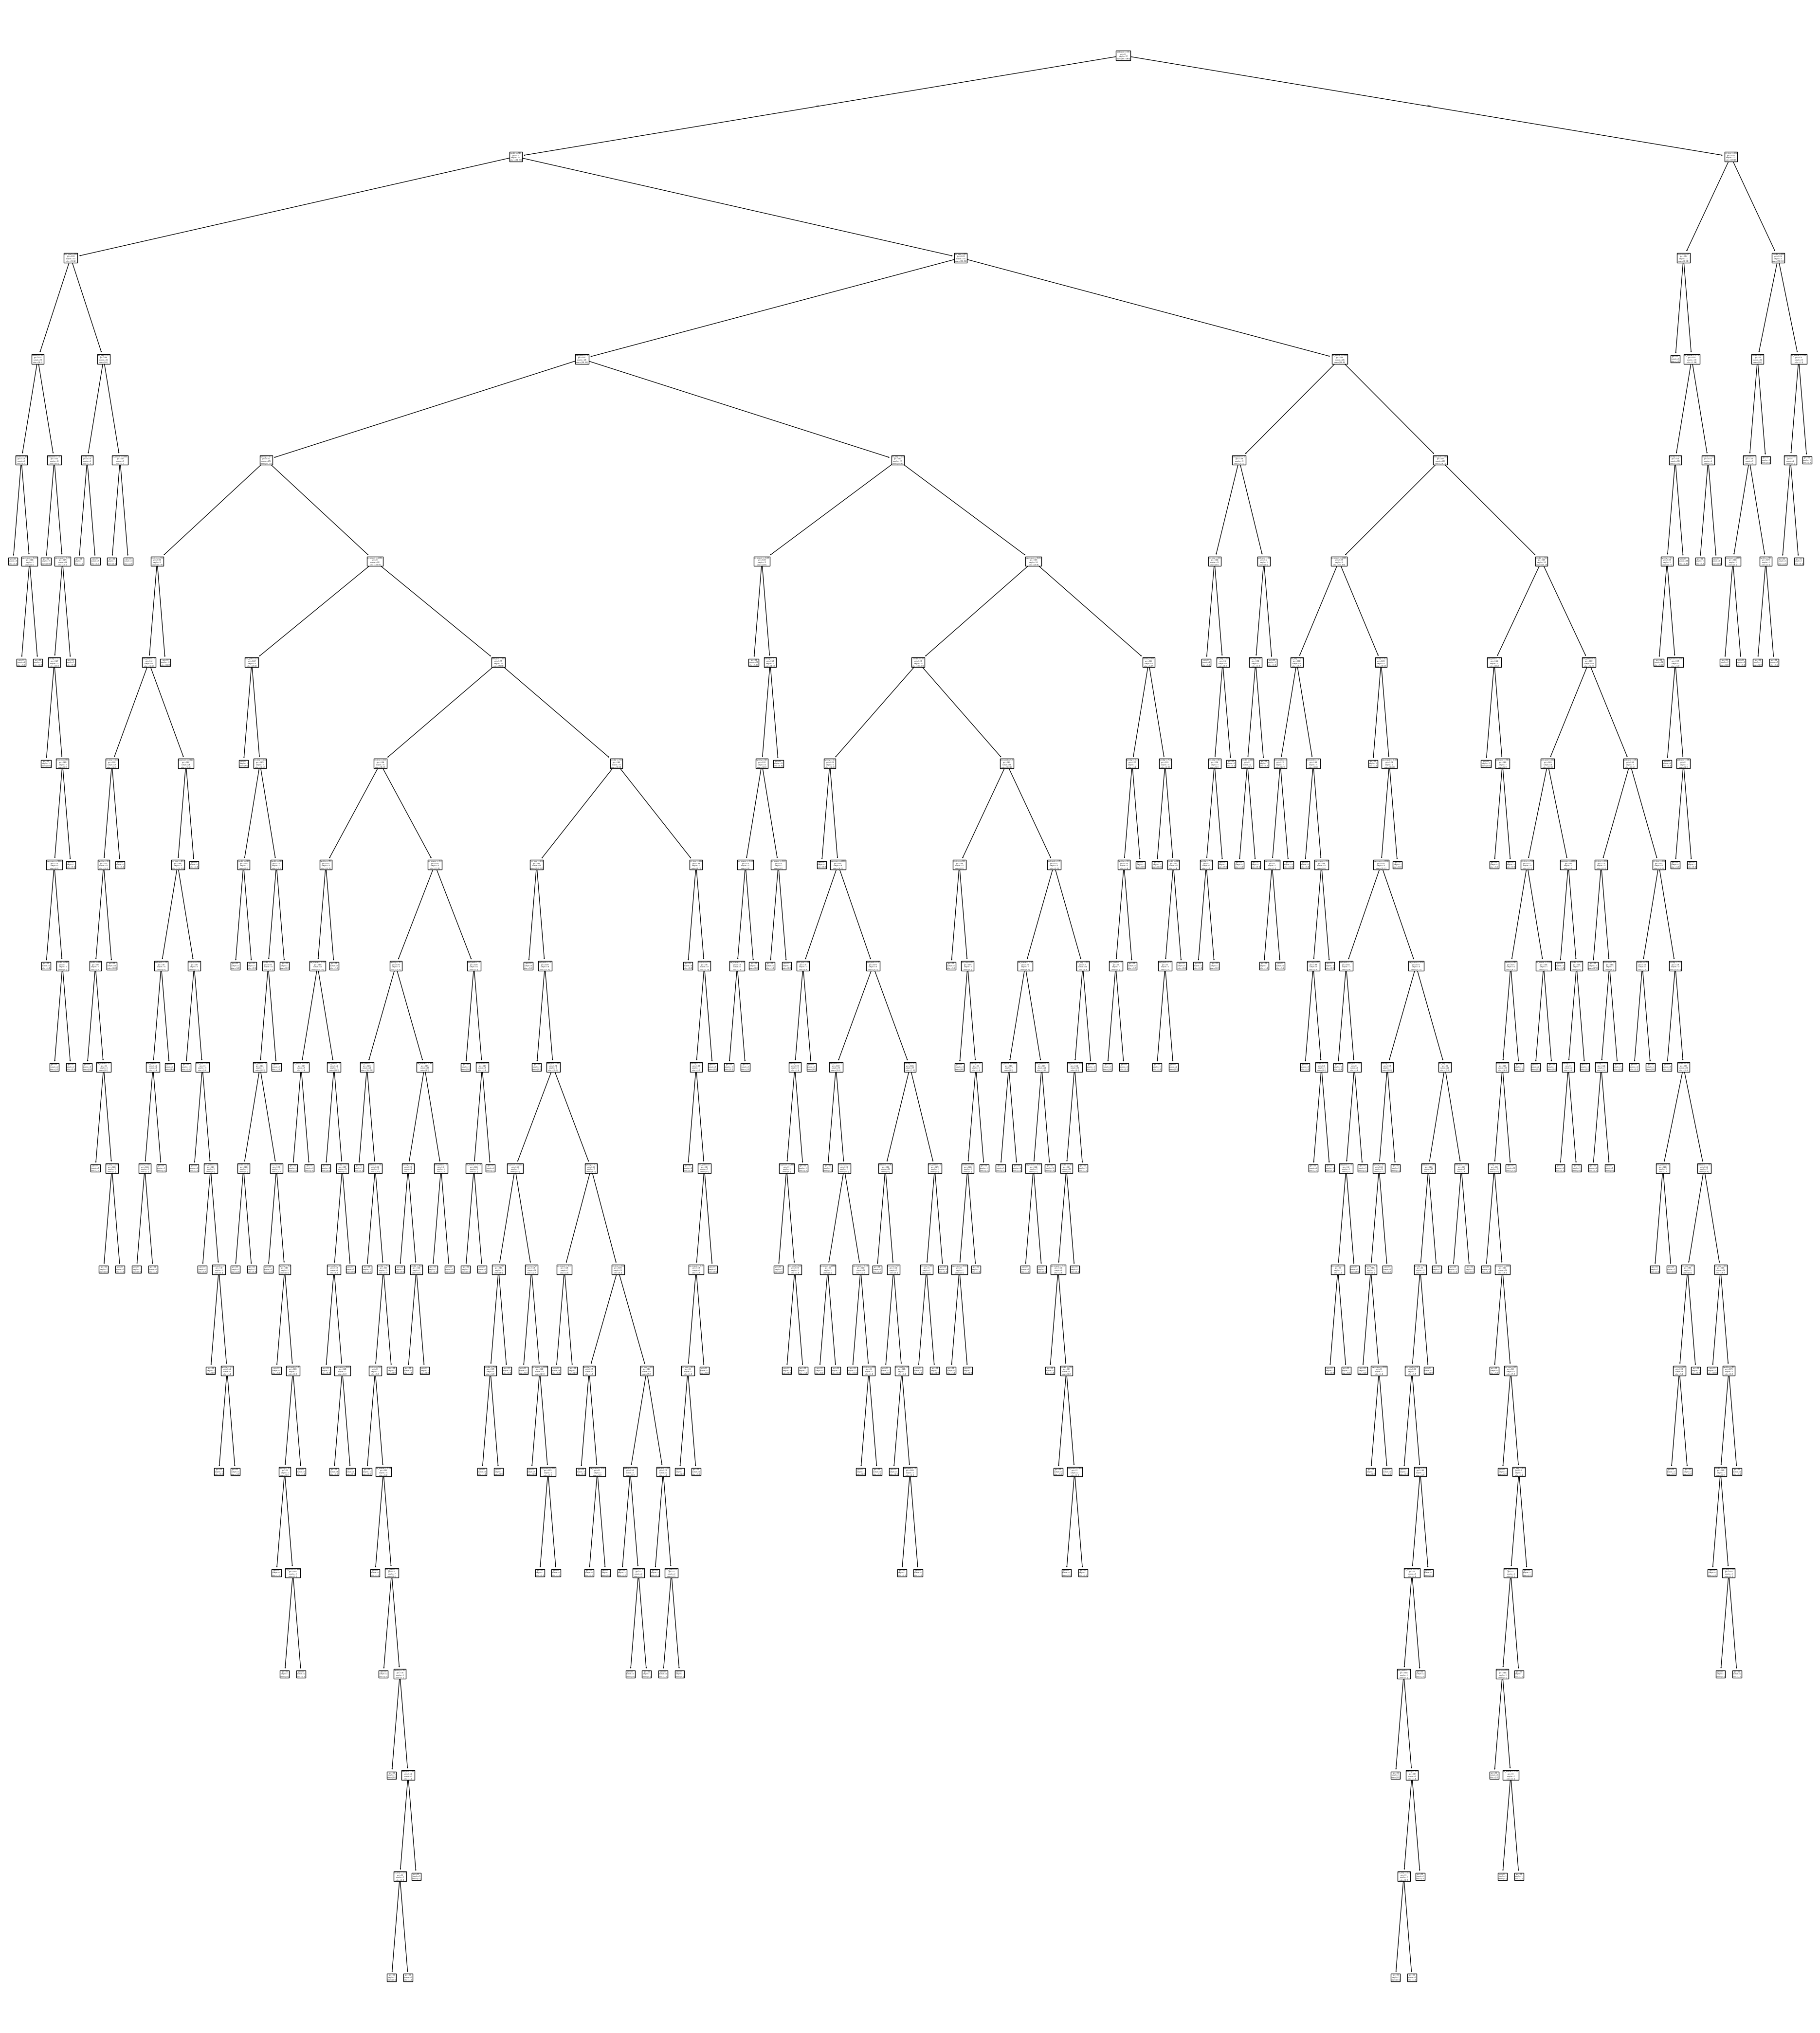

In [80]:
clf = DTC(criterion='gini', random_state=RNG_SEED)
clf.fit(X_train, y_train)

# Plot the unpruned tree
fig, ax = subplots(figsize=(48,54))
plot_tree(clf,
          feature_names=predictors,
          ax=ax);

fig.savefig("fig7.png")

err_unp_train = 1 - accuracy_score(y_train, clf.predict(X_train))
err_bayes_train = 1 - accuracy_score(y_train, ['No'] * len(y_train))

print("Unpruned Model Training Error: " + str(err_unp_train))
print("Naive Bayes Training Error: " + str(err_bayes_train))

In [81]:
ccp_path = clf.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(10,
                  random_state=1,
                  shuffle=True)
grid_ccp = skm.GridSearchCV(clf,
                            {'ccp_alpha': ccp_path.ccp_alphas},
                            refit=True,
                            cv=10,
                            scoring='accuracy')
grid_ccp.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=111),
             param_grid={'ccp_alpha': array([0.        , 0.00050694, 0.00061412, 0.00062033, 0.00068236,
       0.00068236, 0.00068236, 0.00076766, 0.00076766, 0.00076766,
       0.00081883, 0.00081883, 0.00081883, 0.00085295, 0.00087732,
       0.00087732, 0.00087732, 0.00087732, 0.00088707, 0.0008956 ,
       0.00090981, 0.00090981, 0.00090981, 0.000...
       0.00188068, 0.00191061, 0.00191645, 0.00191681, 0.00193882,
       0.00195554, 0.00197397, 0.0020267 , 0.0021051 , 0.00218356,
       0.00223469, 0.00223938, 0.00228733, 0.00243169, 0.00257239,
       0.00257398, 0.00295782, 0.00296164, 0.00305944, 0.00318623,
       0.00340368, 0.00353942, 0.00372379, 0.00375987, 0.00463864,
       0.0047544 , 0.00553232, 0.00653791, 0.02765853, 0.028223  ,
       0.05756375])},
             scoring='accuracy')

In [82]:
print("Best CV Error: " + str(1 - grid_ccp.best_score_))

Best CV Error: 0.28762886597938153


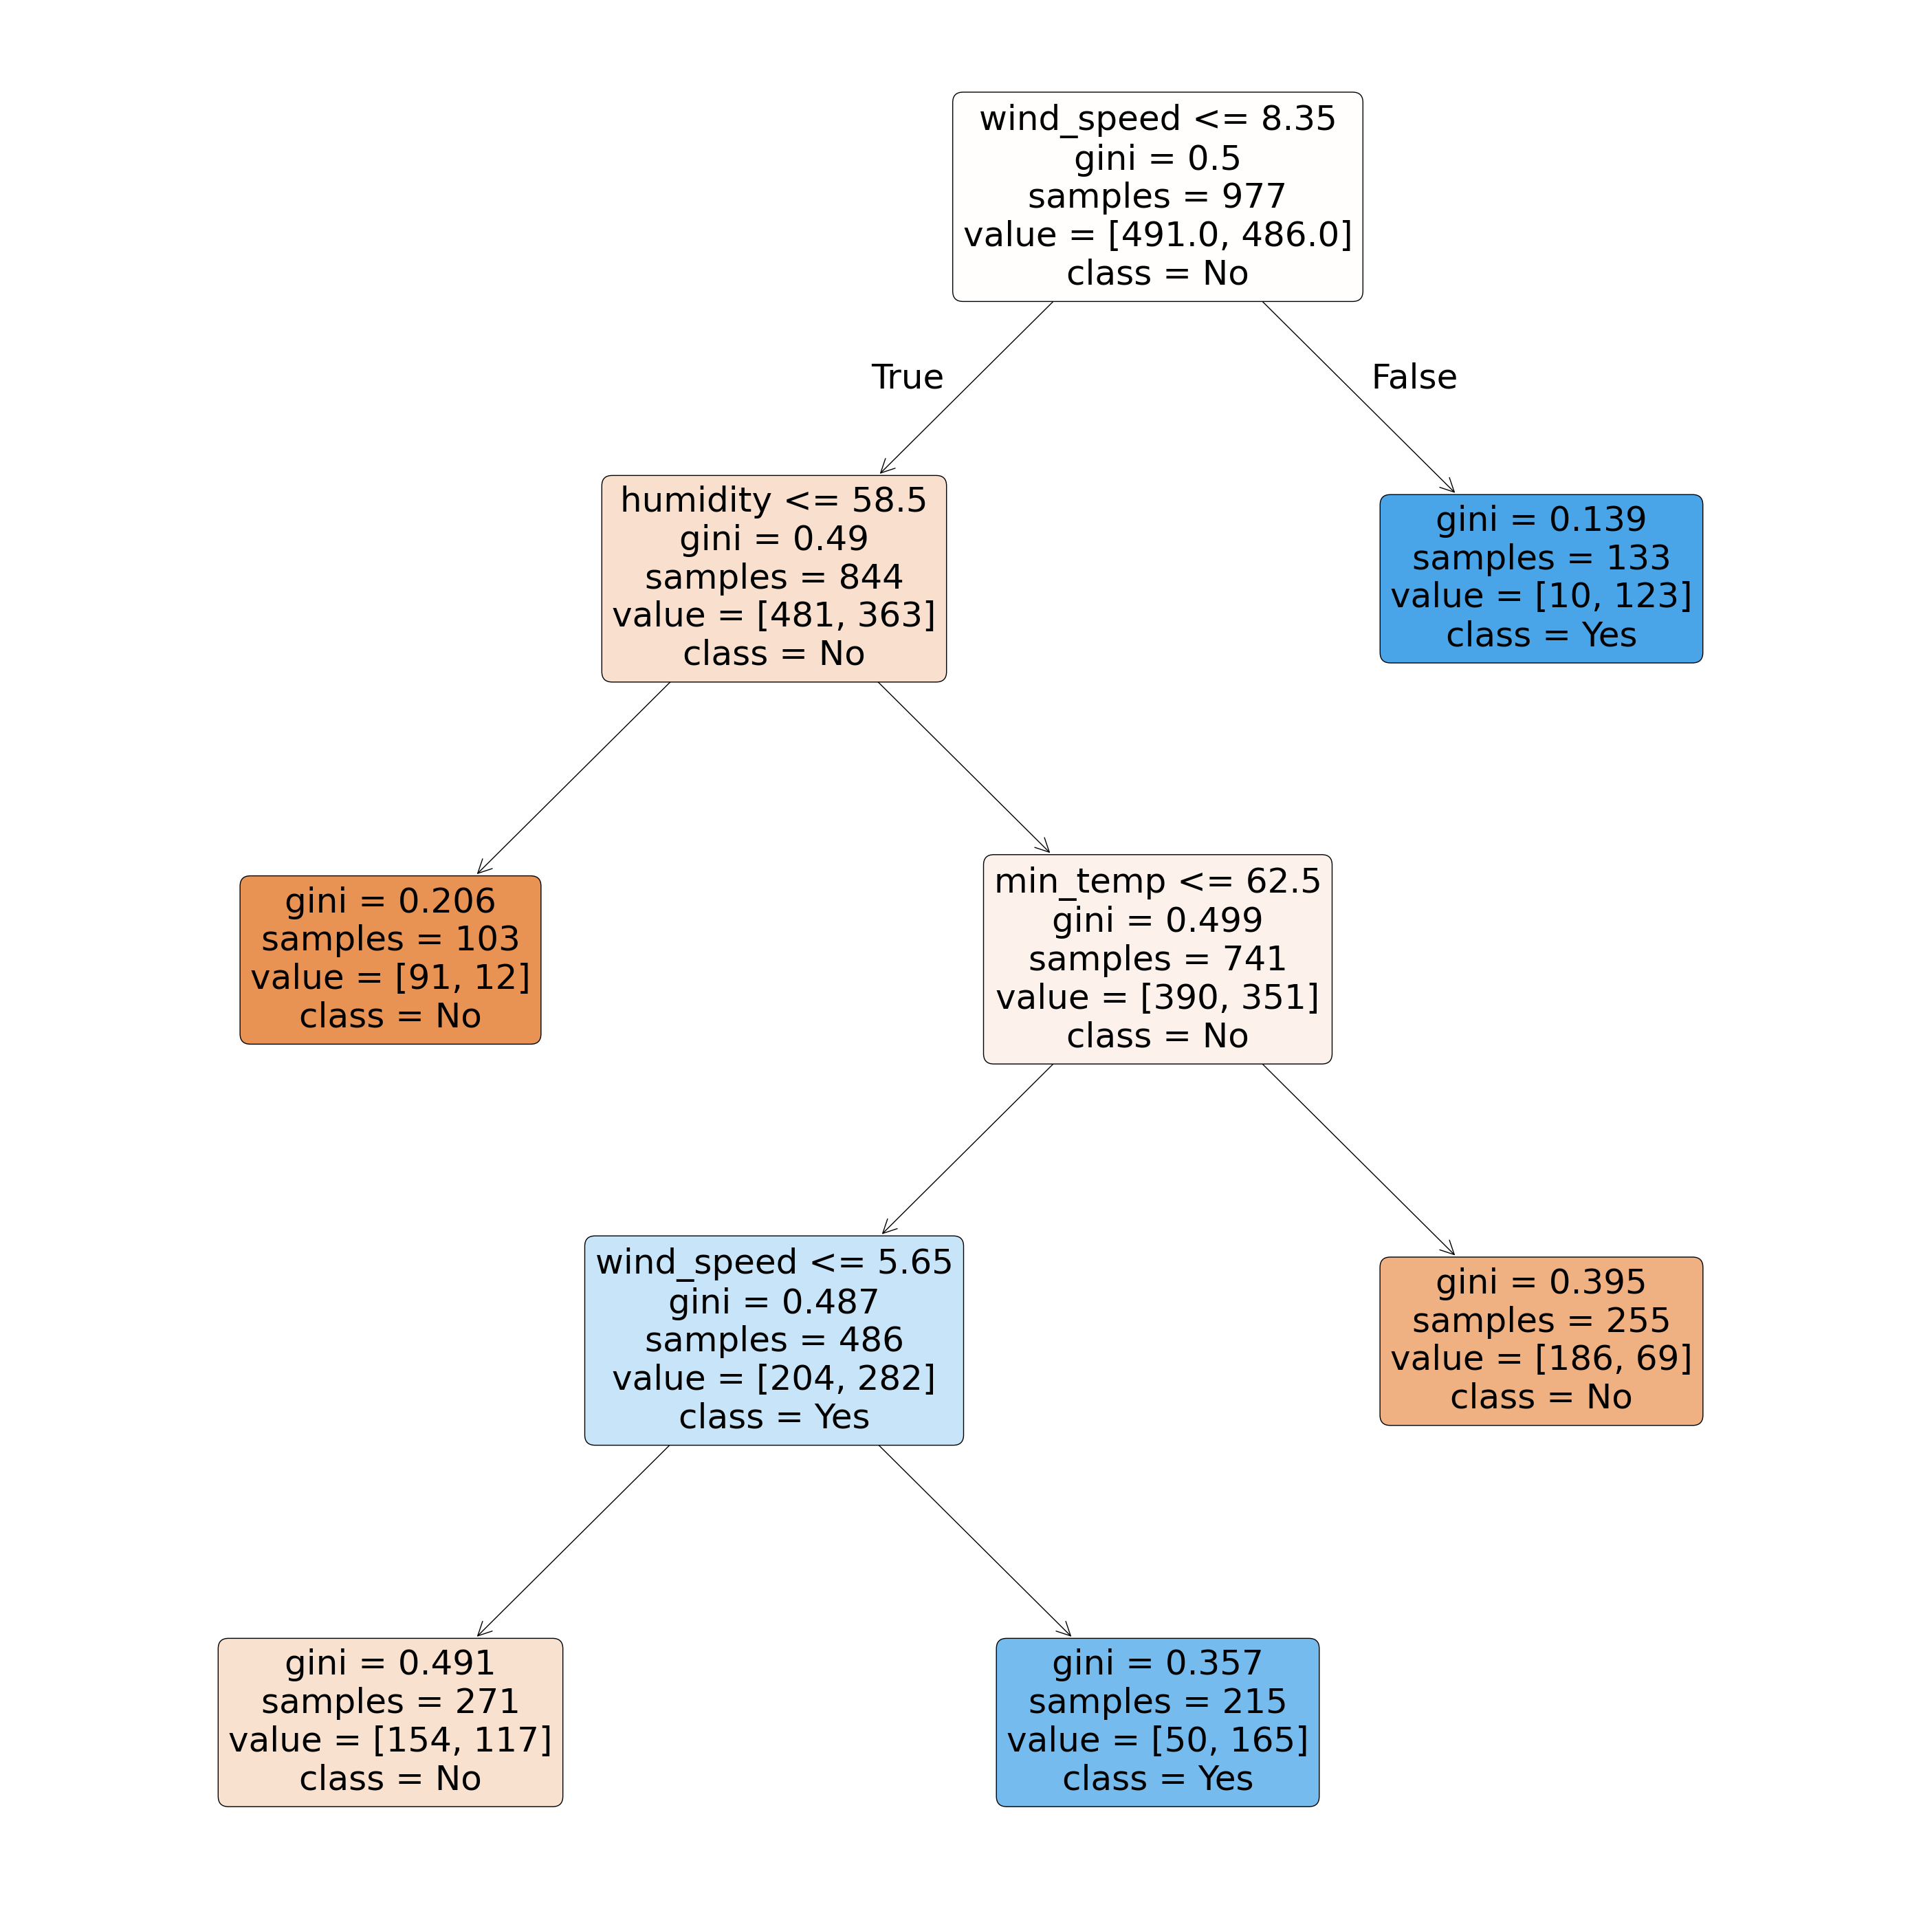

In [83]:
fig, ax = subplots(figsize=(36,36))
best_ccp = grid_ccp.best_estimator_
plot_tree(best_ccp,
          feature_names=predictors,
          ax=ax,
          class_names=['No', 'Yes'],
          rounded=True,
          filled=True,
         fontsize=36);
fig.savefig("fig8.png")

In [84]:
err_ccp_train = 1 - accuracy_score(y_train, best_ccp.predict(X_train))
err_ccp_test = 1 - accuracy_score(y_test, best_ccp.predict(X_test))
err_bayes_test = 1 - accuracy_score(y_test, ['Yes'] * len(y_test))

print("Model Training Error: " + str(err_ccp_train))
print("Naive Bayes Training Error: " + str(err_bayes_train))

print("Model Test Error: " + str(err_ccp_test))
print("Naive Bayes Test Error: " + str(err_bayes_test))
confusion_ccp = confusion_matrix(best_ccp.predict(X_test),
                                 y_test)


confusion_ccp

Model Training Error: 0.26407369498464683
Naive Bayes Training Error: 0.4974411463664279
Model Test Error: 0.273469387755102
Naive Bayes Test Error: 0.4897959183673469


array([[105,  52],
       [ 15,  73]])

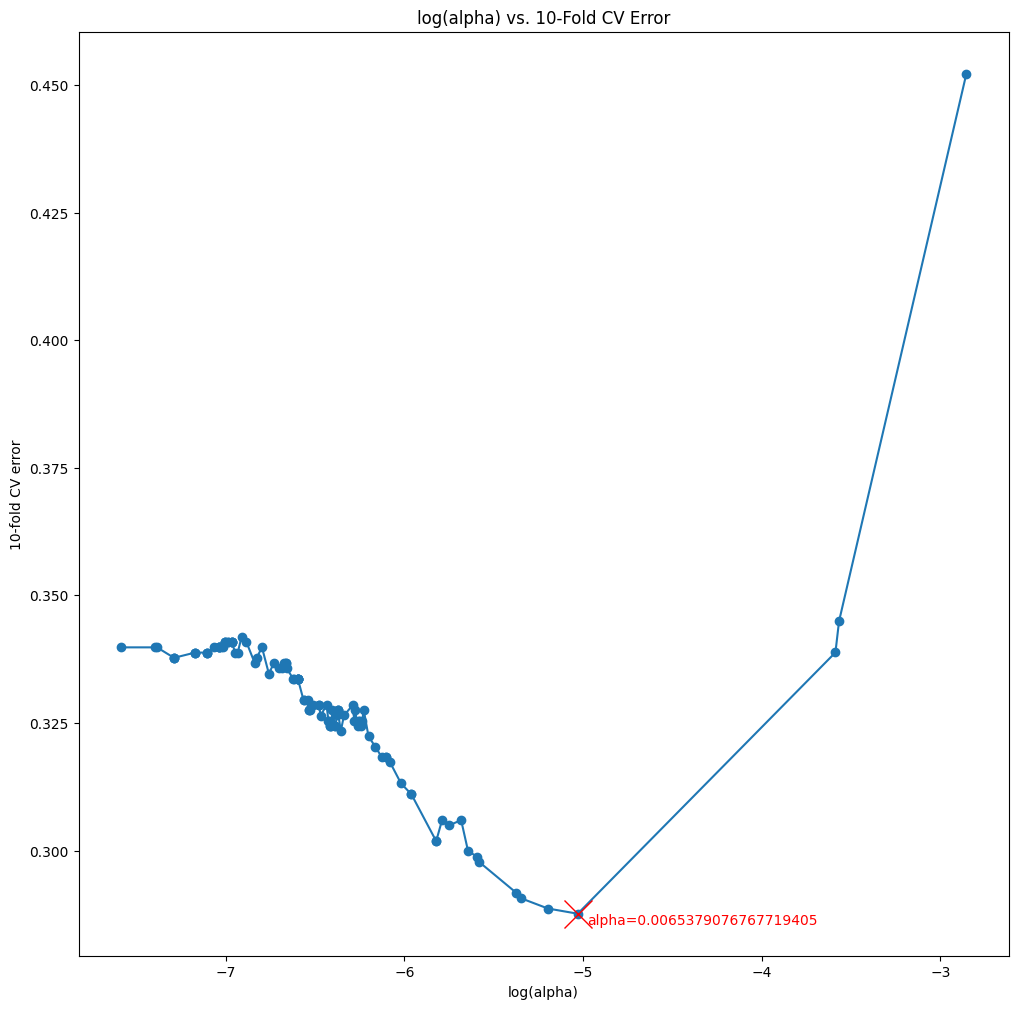

In [85]:
cv_df_ccp = pd.DataFrame(grid_ccp.cv_results_)
alpha_list = np.log([alpha_dict['ccp_alpha'] for alpha_dict in cv_df_ccp['params'][1::]])
err_list = [1 - acc for acc in cv_df_ccp['mean_test_score'][1::]]
min_err = min(err_list)
min_ind = err_list.index(min_err)
best_alpha = alpha_list[min_ind]

plt.figure(figsize=(12,12))

plt.plot(alpha_list, err_list, marker='o')
plt.plot(best_alpha, min_err, marker='x', markersize=20, color='red')
plt.text(best_alpha+0.05, min_err - 0.002, "alpha=" + str(np.exp(best_alpha)), fontsize=10, color='red')
plt.xlabel("log(alpha)"); plt.ylabel("10-fold CV error"); plt.title("log(alpha) vs. 10-Fold CV Error")
plt.savefig("fig15.png");
plt.show();




# 10-Fold ROC for CCP Tree

CCP 10-Fold ROC-AUC: 0.7520230607966456


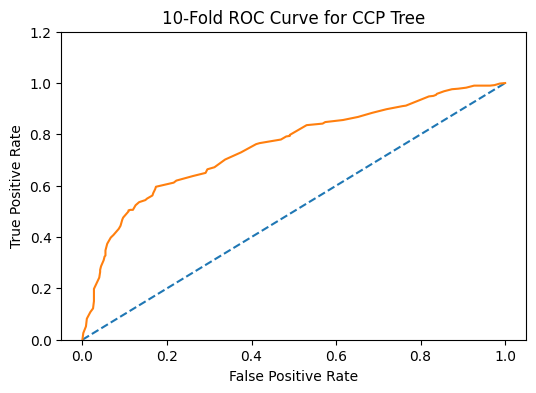

In [86]:
kf_gen = KFold(n_splits=10).split(X_train_df, y_train)

ccp_kf = pd.DataFrame(columns=['prob', 'truth'])

for kf_train, kf_test in kf_gen:
    train_set_X = [X.loc[i] for i in kf_train]
    train_set_y = [y.loc[i] for i in kf_train]
    test_set_X = [X.loc[i] for i in kf_test]
    test_set_y = [y.loc[i] for i in kf_test]
    est = grid_ccp.best_estimator_
    est.fit(train_set_X, train_set_y)
    probs = est.predict_proba(test_set_X)[:,1]
    for i in range(len(test_set_X)):
        ccp_kf.loc[len(ccp_kf)] = {
            'prob': probs[i],
            'truth': test_set_y[i]}

ccp_kf_auc = roc_auc_score(ccp_kf.truth, ccp_kf.prob)
print("CCP 10-Fold ROC-AUC:", ccp_kf_auc)

fpr_ccp_cv, tpr_ccp_cv = roc_curve(ccp_kf.truth, ccp_kf.prob,
                                 pos_label="Yes")[:2]
fig, ax = subplots(figsize=(6,4))
ax.plot([0,1], [0,1], linestyle='--')
ax.plot(fpr_ccp_cv, tpr_ccp_cv, label="CCP Tree")
ax.set_ylabel("True Positive Rate")
ax.set_xlabel("False Positive Rate")
ax.set_title("10-Fold ROC Curve for CCP Tree")
ax.set_ylim(0, 1.2)
fig.savefig("fig20.png")

plt.show()


# Feature Importance for CPP Model

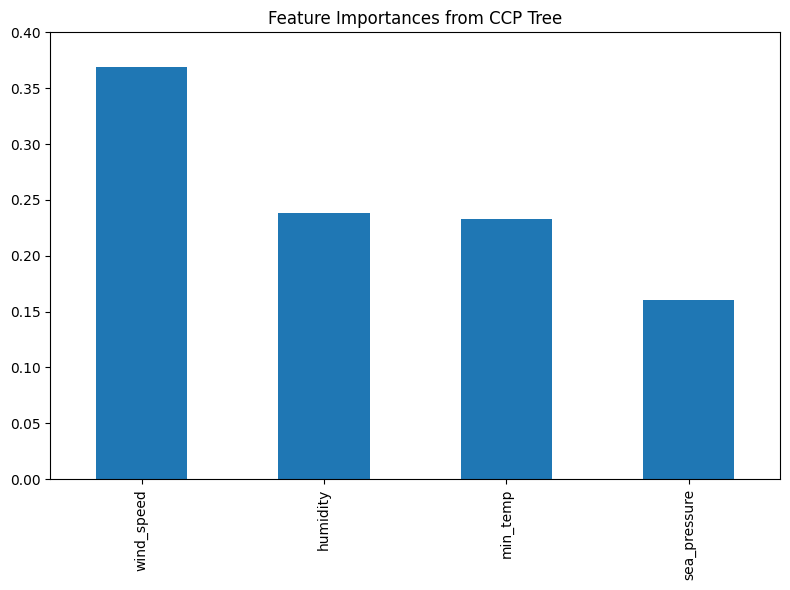

In [87]:
imp_ccp = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
imp_ccp.plot(kind='bar')
plt.title("Feature Importances from CCP Tree")
plt.ylim(0, 0.4)
plt.tight_layout()
plt.savefig("fig3.png")
plt.show()

# Bagging

In [88]:
y_train_bin_s = [1 if will_rain == 'Yes' else 0 for will_rain in y_train_s]

bagger_s = BC(estimator = DTC(random_state=RNG_SEED),
              n_estimators=500,
              bootstrap=True,
              oob_score=True,
              random_state=RNG_SEED+1,
              n_jobs=-1)

bagger_s.fit(X_train_s, y_train_bin_s)
yhat_test_bag_s = bagger_s.predict(X_test_s)
prob_test_bag_s = bagger_s.predict_proba(X_test_s)[:,1]

print("Done.")

Done.


In [89]:
y_test_bin_s = [1 if will_rain == 'Yes' else 0 for will_rain in y_test_s]

err_bag_train_s = 1 - accuracy_score(y_train_bin_s, bagger_s.predict(X_train_s))
err_bag_test_s = 1 - accuracy_score(y_test_bin_s, bagger_s.predict(X_test_s))

print("Bagging Training Error: " + str(err_bag_train_s))
print("Naive Bayes Training Error: " + str(err_bayes_train_s))

print("Bagging Test Error: " + str(err_bag_test_s))
print("Naive Bayes Test Error: " + str(err_bayes_test_s))
confusion_bag = confusion_matrix(bagger_s.predict(X_test_s),
                                 y_test_bin_s)


confusion_bag

Bagging Training Error: 0.0
Naive Bayes Training Error: 0.4980793854033291
Bagging Test Error: 0.2551020408163265
Naive Bayes Test Error: 0.47959183673469385


array([[73, 21],
       [29, 73]])

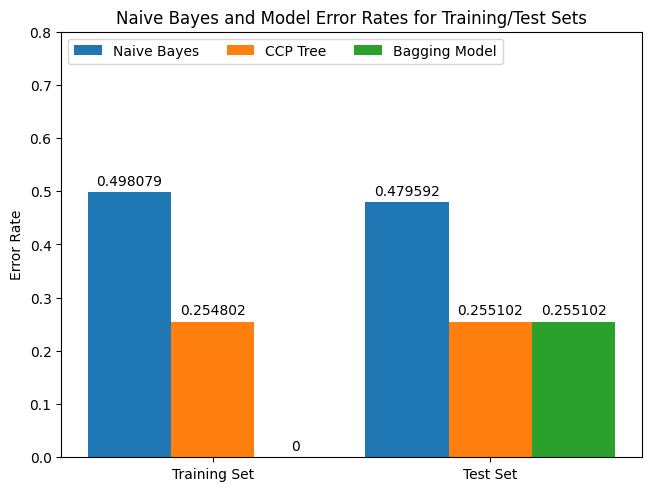

In [90]:
error_sets_bag_s = ("Training Set", "Test Set")
errors_bag_s = {
    'Naive Bayes': (err_bayes_train_s, err_bayes_test_s),
    'CCP Tree': (err_ccp_train_s, err_ccp_test_s),
    'Bagging Model': (err_bag_train_s, err_bag_test_s)
}

x = np.arange(len(error_sets_bag_s))
width = 0.3
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in errors_bag_s.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Error Rate')
ax.set_title('Naive Bayes and Model Error Rates for Training/Test Sets')
ax.set_xticks(x + width, error_sets_bag_s)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 0.8)
fig.savefig("fig5.png")

plt.show()

# Bagging ROC-AUC

Test ROC-AUC: 0.8268669169795578


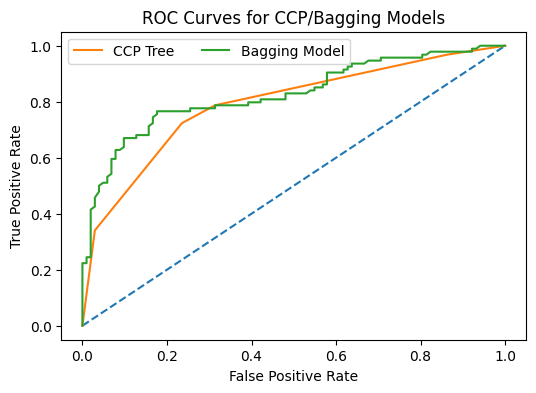

In [91]:
auc_bag = roc_auc_score(y_test_s, prob_test_bag_s)
print("Test ROC-AUC: " + str(roc_auc_score(y_test_s, prob_test_bag_s)))

fpr_bag, tpr_bag = roc_curve(y_test_s, prob_test_bag_s,
                             pos_label="Yes")[:2]
fig, ax = subplots(figsize=(6,4))
ax.plot([0,1], [0,1], linestyle='--')
ax.plot(fpr_ccp, tpr_ccp, label="CCP Tree")
ax.plot(fpr_bag, tpr_bag, label="Bagging Model")
ax.set_ylabel("True Positive Rate")
ax.set_xlabel("False Positive Rate")
ax.set_title("ROC Curves for CCP/Bagging Models")
ax.legend(loc='upper left', ncols=2)
fig.savefig("fig11.png")

plt.show()

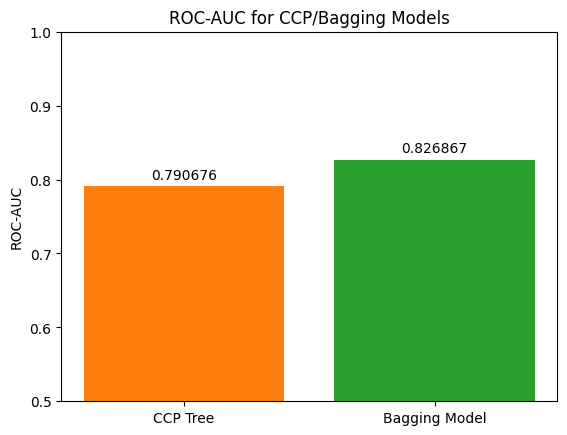

In [92]:
model_names = ["CCP Tree", "Bagging Model"]
aucs = [auc_ccp, auc_bag]
colors = ['tab:orange', 'tab:green']

fig, ax = plt.subplots()

ax.bar_label(ax.bar(model_names, aucs, color=colors), padding=3)
ax.set_ylabel('ROC-AUC')
ax.set_title('ROC-AUC for CCP/Bagging Models')
ax.set_ylim(0.5, 1)
fig.savefig("fig13.png")

plt.show()

# Bagging Model fit to Entire Training Set

In [93]:
y_train_bin = [1 if will_rain == 'Yes' else 0 for will_rain in y_train]

bagger = BC(
    estimator = DTC(random_state=RNG_SEED),
    n_estimators=500,
    bootstrap=True,
    oob_score=True,
    random_state=RNG_SEED+1,
    n_jobs=-1)

bagger.fit(X_train, y_train_bin)
yhat_test_bag = bagger.predict(X_test)
prob_test_bag = bagger.predict_proba(X_test)[:,1]

# bag_cv = validation_curve(bagger,
#                           X_train,
#                           y_train_bin,
#                           param_name = 'n_estimators',
#                           param_range=range(1,201),
#                           cv=10,
#                           n_jobs=-1)
print("Done.")
                        

Done.


In [94]:
# np.savetxt('bagging_cv_data_train.csv', [np.array(range(1,11))] + list(bag_cv[0]), delimiter=',')
# np.savetxt('bagging_cv_data_test.csv', [np.array(range(1,11))] + list(bag_cv[1]), delimiter=',')

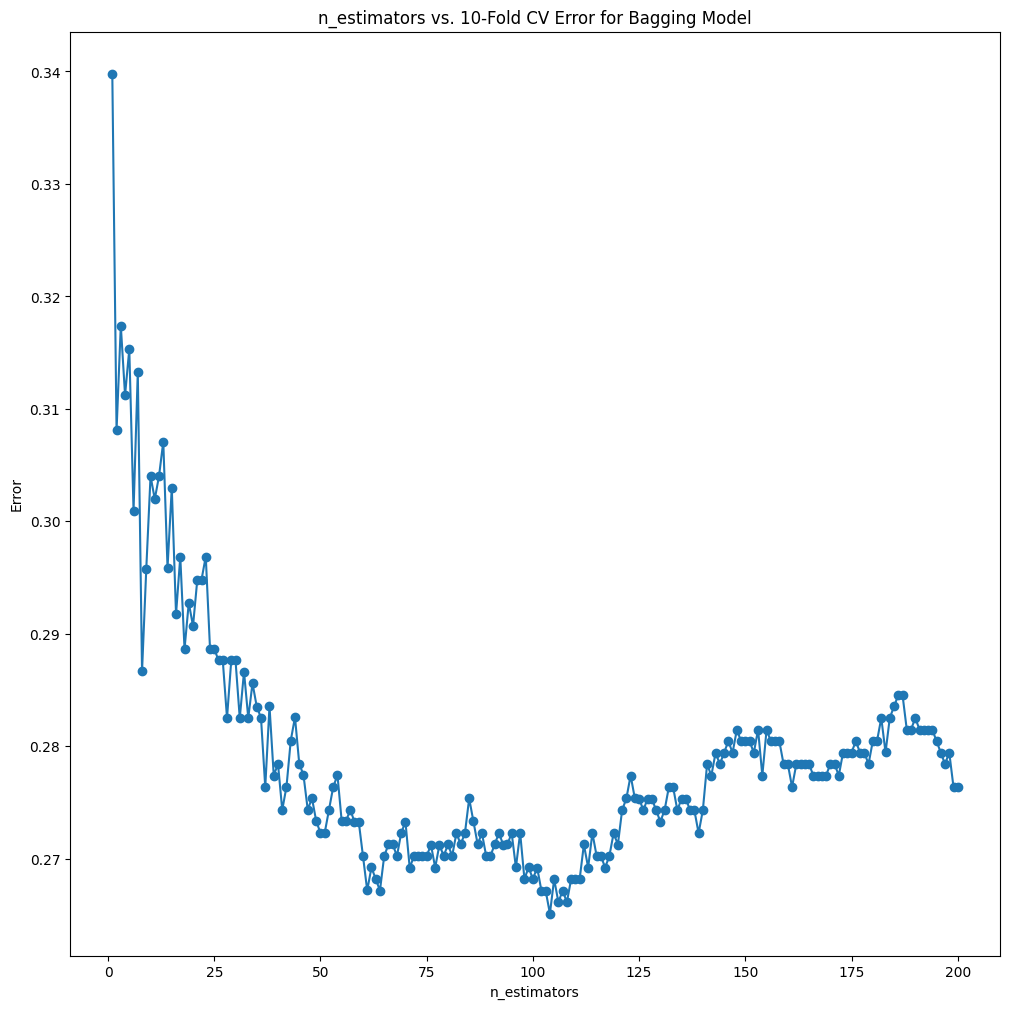

In [95]:
cv_df_bag = pd.read_csv('bagging_cv_data_test.csv')
cv_list_bag = [1 - acc for acc in cv_df_bag.mean(axis=1)]

fig, ax = plt.subplots(figsize=(12,12))

ax.plot(range(1,201), cv_list_bag, marker='o')
ax.set_xlabel("n_estimators");
ax.set_ylabel("Error");
ax.set_title("n_estimators vs. 10-Fold CV Error for Bagging Model")
fig.savefig("fig10.png");

In [96]:
bag_cv = 1 - np.mean(
                cross_val_score(bagger,
                                X_train,
                                y_train_bin,
                                cv=10,
                                n_jobs=-1))
bag_oob = 1 - bagger.oob_score_

print("Bagging CV Error:", bag_cv)
print("Bagging OOB Error:", bag_oob)

Bagging CV Error: 0.2753313696612666
Bagging OOB Error: 0.28454452405322417


In [97]:
y_test_bin = [1 if will_rain == 'Yes' else 0 for will_rain in y_test]

err_bag_train = 1 - accuracy_score(y_train_bin, bagger.predict(X_train))
err_bag_test = 1 - accuracy_score(y_test_bin, bagger.predict(X_test))

print("Bagging Training Error: " + str(err_bag_train))
print("Naive Bayes Training Error: " + str(err_bayes_train))

print("Bagging Test Error: " + str(err_bag_test))
print("Naive Bayes Test Error: " + str(err_bayes_test))
confusion_bag = confusion_matrix(bagger.predict(X_test),
                                 y_test_bin)


confusion_bag

Bagging Training Error: 0.0
Naive Bayes Training Error: 0.4974411463664279
Bagging Test Error: 0.24897959183673468
Naive Bayes Test Error: 0.4897959183673469


array([[93, 34],
       [27, 91]])

# Feature Importance for Bagging Model

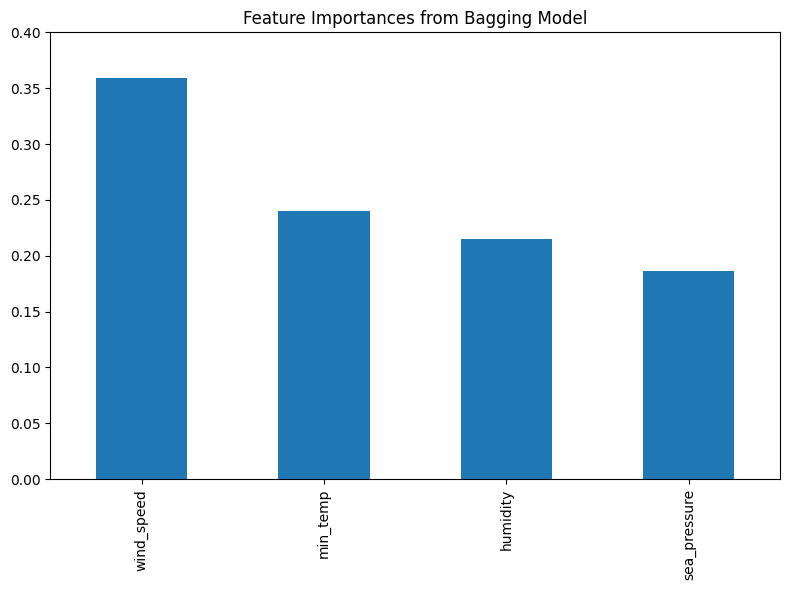

In [98]:
imp_bag = pd.Series(np.mean(
            [est.feature_importances_ for est in bagger.estimators_],
            axis=0), index=X.columns
          ).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
imp_bag.plot(kind='bar')
plt.title("Feature Importances from Bagging Model")
plt.ylim(0, 0.4)
plt.tight_layout()
plt.savefig("fig12.png")
plt.show()

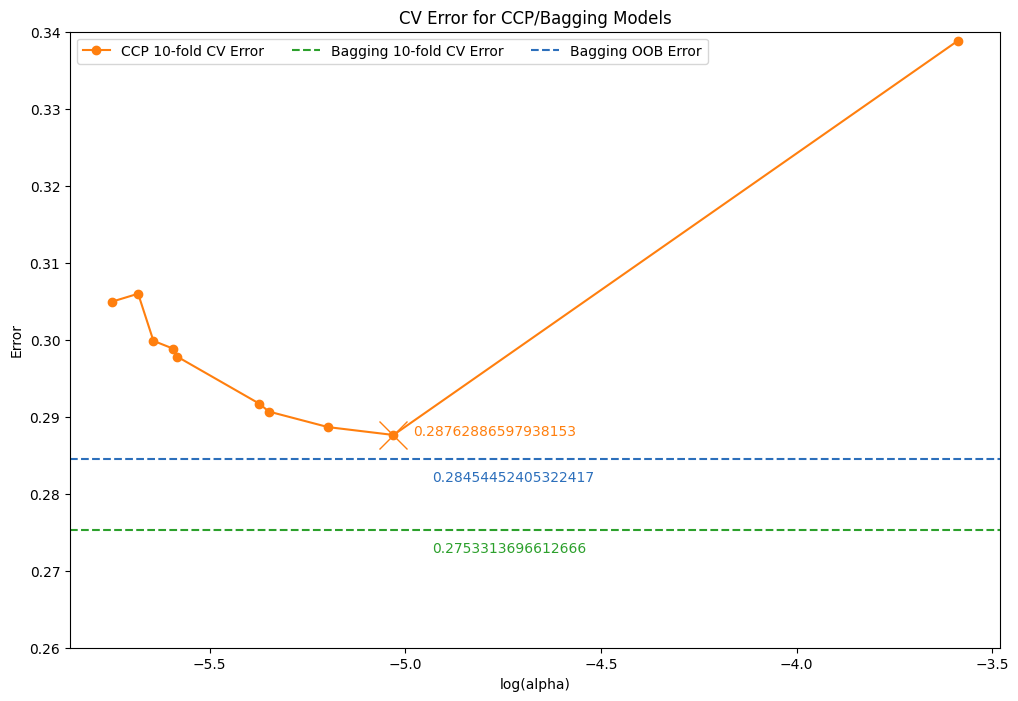

In [99]:
short_alpha_list = alpha_list[-3:-13:-1]
short_err_list = err_list[-3:-13:-1]

plt.figure(figsize=(12,8))

plt.plot(short_alpha_list, short_err_list, marker='o', color='tab:orange', label='CCP 10-fold CV Error')
plt.plot(best_alpha, min_err, marker='x', markersize=20, color='tab:orange')
plt.axhline(y=bag_cv, color='tab:green', linestyle='--', label='Bagging 10-fold CV Error')
plt.axhline(y=bag_oob, color='#2c6fbb', linestyle='--', label='Bagging OOB Error')
plt.text(best_alpha+0.05, min_err, str(min_err), fontsize=10, color='tab:orange')
plt.text(best_alpha+0.1, bag_cv - 0.003, str(bag_cv), fontsize=10, color='tab:green')
plt.text(best_alpha+0.1, bag_oob - 0.003, str(bag_oob), fontsize=10, color='#2c6fbb')
plt.xlabel("log(alpha)"); plt.ylabel("Error"); plt.title("CV Error for CCP/Bagging Models")
plt.legend(loc='upper left', ncols=3)
plt.ylim(0.26, 0.34)
plt.savefig("fig14.png");
plt.show();



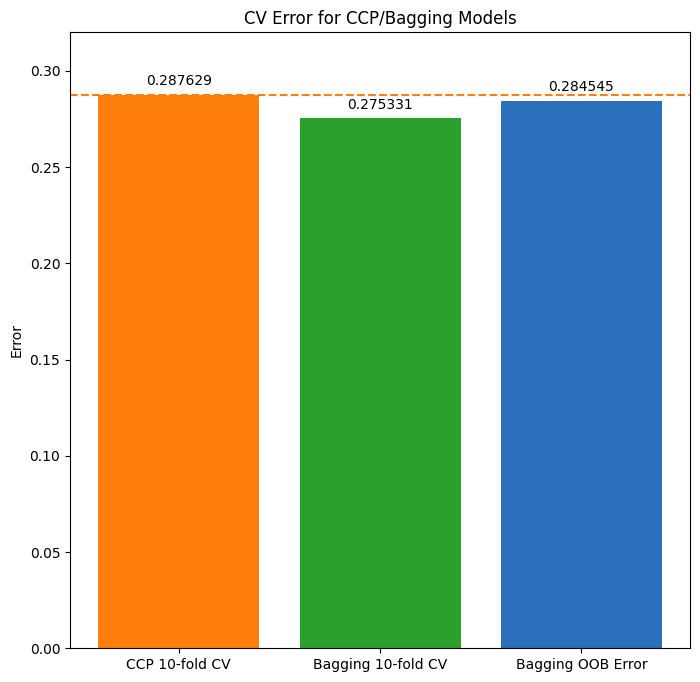

In [100]:
err_names = ["CCP 10-fold CV", "Bagging 10-fold CV", "Bagging OOB Error"]
errs = [min_err, bag_cv, bag_oob]
colors_err = ['tab:orange', 'tab:green', '#2c6fbb']

fig, ax = plt.subplots(figsize=(8,8))

ax.bar_label(ax.bar(err_names, errs, color=colors_err), padding=4.5)
ax.set_ylabel('Error')
ax.set_title('CV Error for CCP/Bagging Models')
ax.set_ylim(0, 0.32)
ax.axhline(y=min_err, color='tab:orange', linestyle='--', )
fig.savefig("fig13.png")

plt.show()

# Random Forest

In [101]:
mf_list = [1, 2, 3]
rf_columns = ['max_features', 'model', 'cv', 'oob', 'train_err', 'test_err', 'prob_test', 'auc']
rf_results_s = pd.DataFrame(columns=rf_columns)

for mf in mf_list:
    rf_s = RF(n_estimators=500,
              max_features=mf,
              oob_score=True,
              random_state=RNG_SEED,
              n_jobs=-1)
    cv = 1 - np.mean(cross_val_score(rf_s,
                                     X_train_s,
                                     y_train_bin_s,
                                     cv=10,
                                     n_jobs=-1))
    rf_s.fit(X_train_s, y_train_bin_s)
    train_err = 1 - accuracy_score(y_train_bin_s, rf_s.predict(X_train_s))
    test_err = 1 - accuracy_score(y_test_bin_s, rf_s.predict(X_test_s))
    prob_test = rf_s.predict_proba(X_test_s)[:,1]
    oob = 1 - rf_s.oob_score_
    auc = roc_auc_score(y_test_s, prob_test)
    rf_results_s.loc[len(rf_results_s)] = {
        'max_features': mf,
        'model': rf_s,
        'cv': cv,
        'oob': oob,
        'train_err': train_err,
        'test_err': test_err,
        'prob_test': prob_test,
        'auc': auc }

rf_results_s

max_features                                              model        cv  \
0             1  (DecisionTreeClassifier(max_features=1, random...  0.274116   
1             2  (DecisionTreeClassifier(max_features=2, random...  0.277962   
2             3  (DecisionTreeClassifier(max_features=3, random...  0.281759   

        oob  train_err  test_err  \
0  0.280410        0.0  0.244898   
1  0.288092        0.0  0.250000   
2  0.297055        0.0  0.255102   

                                           prob_test       auc  
0  [0.466, 0.896, 0.948, 0.458, 0.872, 0.34, 0.32...  0.831300  
1  [0.496, 0.928, 0.974, 0.458, 0.826, 0.316, 0.2...  0.829735  
2  [0.528, 0.924, 0.982, 0.46, 0.846, 0.346, 0.31...  0.828223

In [102]:
best_idx_rf_s = rf_results_s['oob'].idxmin()
best_rf_s = rf_results_s.loc[best_idx_rf_s]

print("Best Random Forest Training Error:", best_rf_s.train_err)
print("Naive Bayes Training Error:", err_bayes_train_s)

print("Best Random Forest Test Error:", best_rf_s.test_err)
print("Naive Bayes Test Error:", err_bayes_test_s)
confusion_rf_s = confusion_matrix(best_rf_s.model.predict(X_test_s),
                                 y_test_bin_s)


confusion_rf_s

Best Random Forest Training Error: 0.0
Naive Bayes Training Error: 0.4980793854033291
Best Random Forest Test Error: 0.24489795918367352
Naive Bayes Test Error: 0.47959183673469385


array([[76, 22],
       [26, 72]])

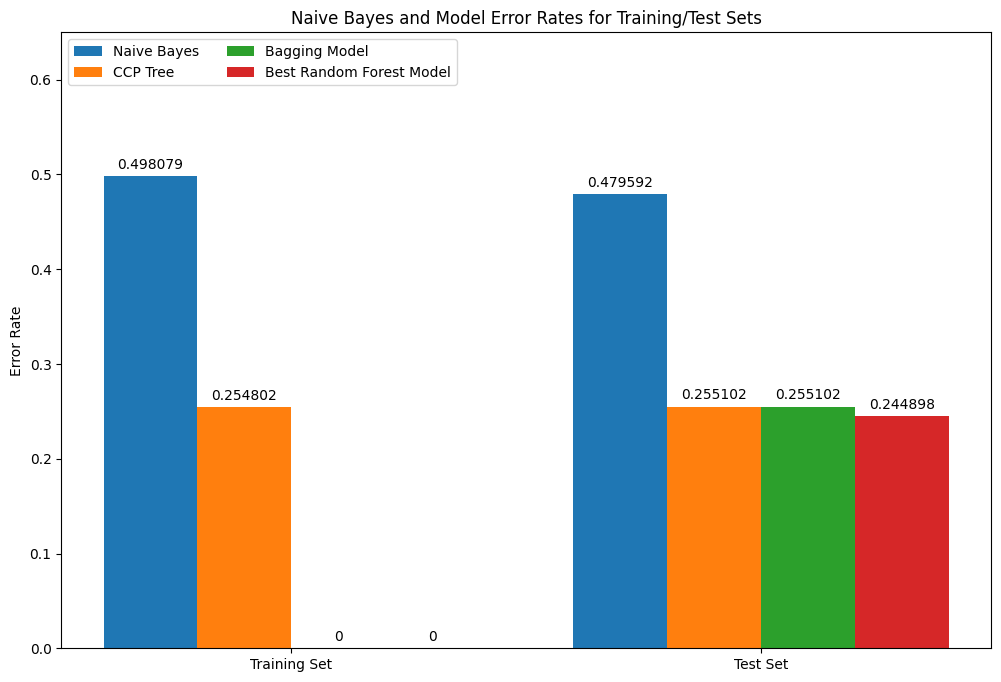

In [103]:
error_sets_rf_s = ("Training Set", "Test Set")
errors_rf_s = {
    'Naive Bayes': (err_bayes_train_s, err_bayes_test_s),
    'CCP Tree': (err_ccp_train_s, err_ccp_test_s),
    'Bagging Model': (err_bag_train_s, err_bag_test_s),
    'Best Random Forest Model': (best_rf_s.train_err, best_rf_s.test_err)
}

x = np.arange(len(error_sets_rf_s))
width = 0.2
multiplier = 0

fig, ax = plt.subplots(figsize=(12,8))

for attribute, measurement in errors_rf_s.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Error Rate')
ax.set_title('Naive Bayes and Model Error Rates for Training/Test Sets')
ax.set_xticks(x + width*1.5, error_sets_bag_s)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0, 0.65)
fig.savefig("fig16.png")

plt.show()

# Random Forest ROC-AUC

Test ROC-AUC: 0.8312995410930331


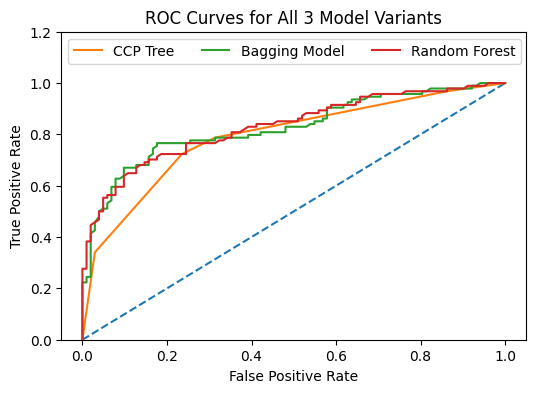

In [104]:
auc_rf = roc_auc_score(y_test_s, best_rf_s.prob_test)
print("Test ROC-AUC:", auc_rf)

fpr_rf_s, tpr_rf_s = roc_curve(y_test_s, best_rf_s.prob_test,
                               pos_label="Yes")[:2]
fig, ax = subplots(figsize=(6,4))
ax.plot([0,1], [0,1], linestyle='--')
ax.plot(fpr_ccp, tpr_ccp, label="CCP Tree")
ax.plot(fpr_bag, tpr_bag, label="Bagging Model")
ax.plot(fpr_rf_s, tpr_rf_s, label="Random Forest")
ax.set_ylabel("True Positive Rate")
ax.set_xlabel("False Positive Rate")
ax.set_title("ROC Curves for All 3 Model Variants")
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1.2)
fig.savefig("fig17.png")

plt.show()

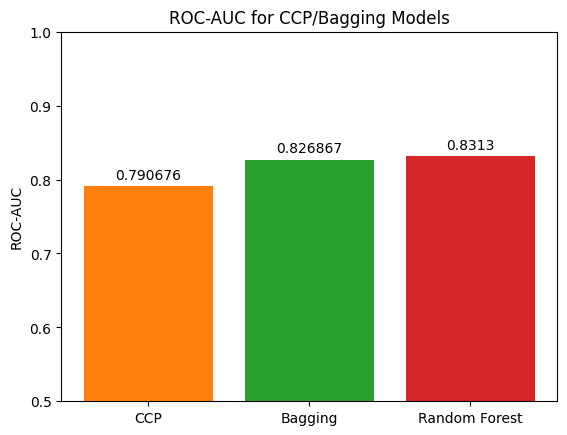

In [105]:
model_names = ["CCP", "Bagging", "Random Forest"]
aucs = [auc_ccp, auc_bag, best_rf_s.auc]
colors = ['tab:orange', 'tab:green', 'tab:red']

fig, ax = plt.subplots()

ax.bar_label(ax.bar(model_names, aucs, color=colors), padding=3)
ax.set_ylabel('ROC-AUC')
ax.set_title('ROC-AUC for CCP/Bagging Models')
ax.set_ylim(0.5, 1)
fig.savefig("fig13.png")

plt.show()

# Random Forest fit to Entire Training Set

In [106]:

rf_results = pd.DataFrame(columns=rf_columns)

for mf in mf_list:
    rf = RF(n_estimators=500,
            max_features=mf,
            oob_score=True,
            random_state=RNG_SEED,
            min_impurity_decrease=0,
            n_jobs=-1)
    cv = 1 - np.mean(cross_val_score(rf,
                                     X_train,
                                     y_train_bin,
                                     cv=10,
                                     n_jobs=-1))
    rf.fit(X_train, y_train_bin)
    train_err = 1 - accuracy_score(y_train_bin, rf.predict(X_train))
    test_err = 1 - accuracy_score(y_test_bin, rf.predict(X_test))
    prob_test = rf.predict_proba(X_test)[:,1]
    oob = 1 - rf.oob_score_
    auc = roc_auc_score(y_test, prob_test)
    rf_results.loc[len(rf_results)] = {
        'max_features': mf,
        'model': rf,
        'cv': cv,
        'oob': oob,
        'train_err': train_err,
        'test_err': test_err,
        'prob_test': prob_test,
        'auc': auc }

rf_results

max_features                                              model        cv  \
0             1  (DecisionTreeClassifier(max_features=1, min_im...  0.263076   
1             2  (DecisionTreeClassifier(max_features=2, min_im...  0.273301   
2             3  (DecisionTreeClassifier(max_features=3, min_im...  0.276362   

        oob  train_err  test_err  \
0  0.275333        0.0  0.240816   
1  0.270215        0.0  0.236735   
2  0.279427        0.0  0.253061   

                                           prob_test       auc  
0  [0.484, 0.28, 0.942, 0.158, 0.932, 0.72, 0.926...  0.811500  
1  [0.534, 0.25, 0.97, 0.152, 0.912, 0.73, 0.934,...  0.807867  
2  [0.532, 0.216, 0.992, 0.15, 0.918, 0.738, 0.94...  0.807167

# Choosing the Best RF Model via Cross-Validation

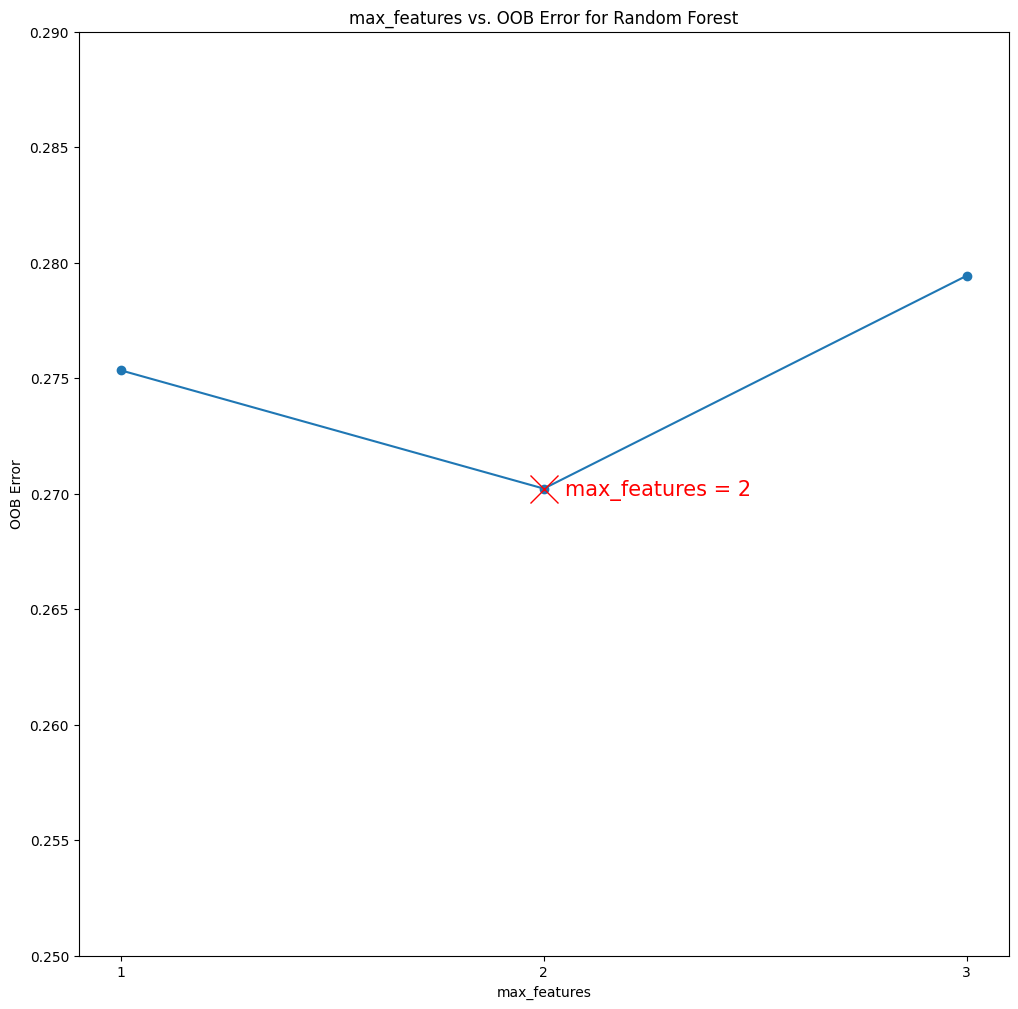

Random Forest CV Error: 0.2733010730065223
Random Forest OOB Error: 0.27021494370522003


In [107]:
best_idx_rf = rf_results['oob'].idxmin()
best_rf = rf_results.loc[best_idx_rf]
rf_oob_list = [rf.oob for rf in [rf_results.loc[i] for i in range(3)]]

plt.figure(figsize=(12,12))

plt.plot(mf_list, rf_oob_list, marker='o')
plt.plot(best_rf.max_features, best_rf.oob, marker='x', markersize=20, color='red')
plt.text(best_rf.max_features+0.05, best_rf.oob-0.0003, "max_features = 2", fontsize=15, color='red')
plt.xlabel("max_features"); plt.ylabel("OOB Error"); plt.title("max_features vs. OOB Error for Random Forest")
plt.savefig("fig24.png");
plt.ylim(0.25, 0.29)
plt.xticks(mf_list)
plt.show();

print("Random Forest CV Error:", best_rf.cv)
print("Random Forest OOB Error:", best_rf.oob)

Random Forest Training Error: 0.0
Naive Bayes Training Error: 0.4974411463664279
Random Forest Test Error: 0.23673469387755097
Naive Bayes Test Error: 0.4897959183673469


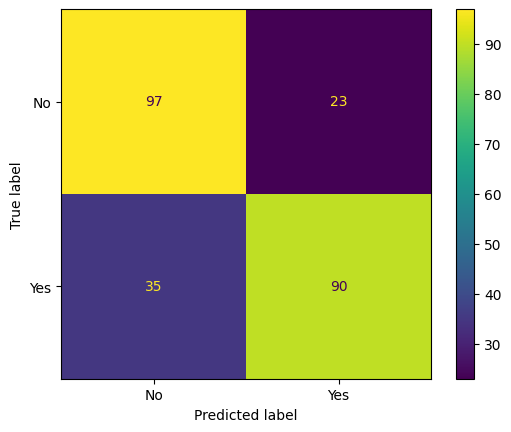

In [120]:
print("Random Forest Training Error:", best_rf.train_err)
print("Naive Bayes Training Error:", err_bayes_train)

print("Random Forest Test Error:", best_rf.test_err)
print("Naive Bayes Test Error:", err_bayes_test)
confusion_rf = confusion_matrix(y_test_bin,
                                best_rf.model.predict(X_test))


rf_matrix = ConfusionMatrixDisplay(confusion_rf, display_labels=['No', 'Yes'])
rf_matrix.plot()
rf_matrix.figure_.savefig("fig26.png")

# Feature Importance for Random Forest

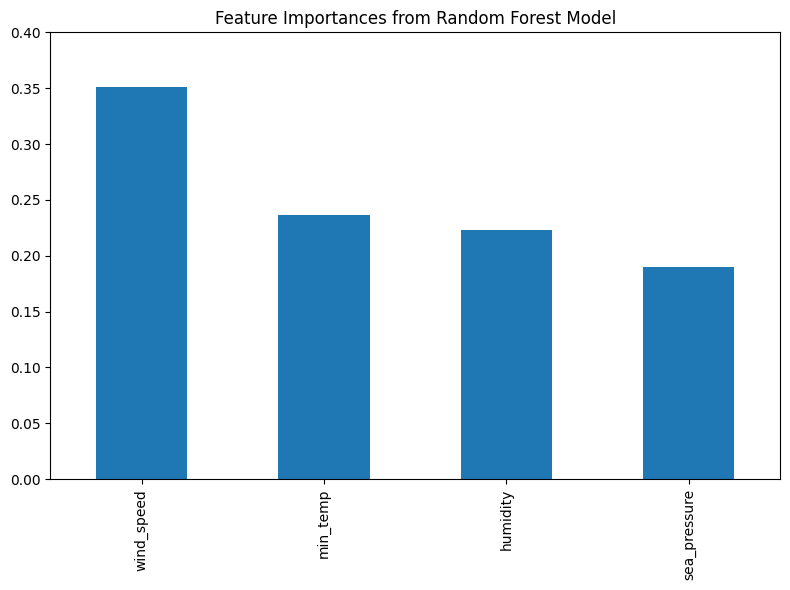

In [109]:
imp_rf = pd.Series(best_rf.model.feature_importances_,
                   index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
imp_rf.plot(kind='bar')
plt.title("Feature Importances from Random Forest Model")
plt.ylim(0, 0.4)
plt.tight_layout()
plt.savefig("fig18.png")
plt.show()

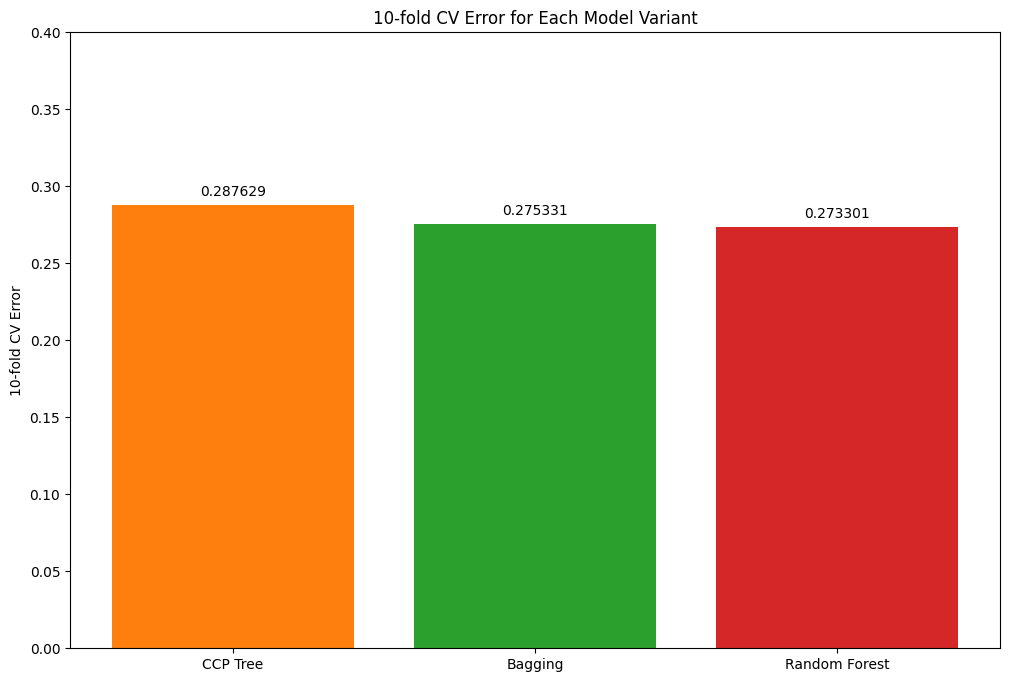

In [111]:
cv_err_names = ["CCP Tree", "Bagging", "Random Forest"]
cv_errs = [min_err, bag_cv, best_rf.cv]
colors_cv_err = ['tab:orange', 'tab:green', 'tab:red']

fig, ax = plt.subplots(figsize=(12,8))

ax.bar_label(ax.bar(cv_err_names, cv_errs, color=colors_cv_err), padding=4.5)
ax.set_ylabel('10-fold CV Error')
ax.set_title('10-fold CV Error for Each Model Variant')
ax.set_ylim(0, .4)
# ax.axhline(y=min_err, color='tab:orange', linestyle='--', )
fig.savefig("fig19.png")

plt.show()

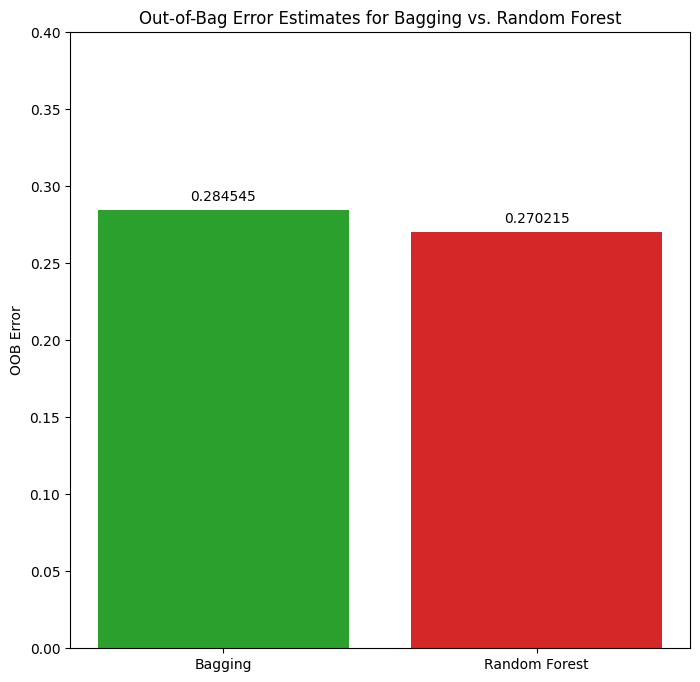

In [112]:
oob_err_names = ["Bagging", "Random Forest"]
oob_errs = [bag_oob, best_rf.oob]
colors_oob_err = ['tab:green', 'tab:red']

fig, ax = plt.subplots(figsize=(8,8))

ax.bar_label(ax.bar(oob_err_names, oob_errs, color=colors_oob_err), padding=4.5)
ax.set_ylabel('OOB Error')
ax.set_title('Out-of-Bag Error Estimates for Bagging vs. Random Forest')
ax.set_ylim(0, .4)
# ax.axhline(y=min_err, color='tab:orange', linestyle='--', )
fig.savefig("fig20.png")

plt.show()

# Naive Bayes, Training, and Test Error with Random Forest Model

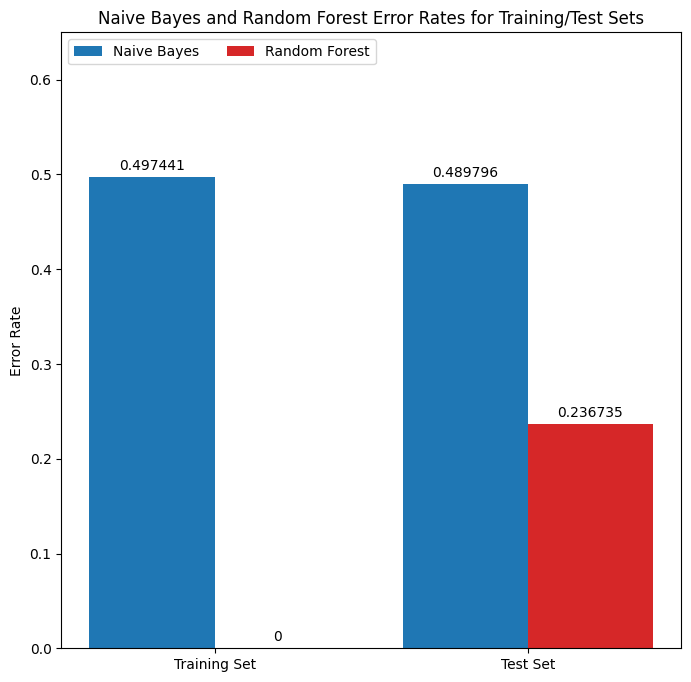

In [113]:
error_sets_rf = ("Training Set", "Test Set")
errors_rf = {
    'Naive Bayes': [(err_bayes_train, err_bayes_test), 'tab:blue'],
    'Random Forest': [(best_rf.train_err, best_rf.test_err), 'tab:red'] 
}

x = np.arange(len(error_sets_rf))
width = 0.4
multiplier = 0

fig, ax = plt.subplots(figsize=(8,8))

for attribute, measurement in errors_rf.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement[0], width, label=attribute, color=measurement[1])
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Error Rate')
ax.set_title('Naive Bayes and Random Forest Error Rates for Training/Test Sets')
ax.set_xticks(x + width*0.5, error_sets_rf)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0, 0.65)
fig.savefig("fig25.png")

plt.show()

# Cross-Validated ROC-AUC for All Model Variants

OOB Bagging ROC-AUC: 0.7907080536068996
OOB Random Forest ROC-AUC: 0.80231198612054


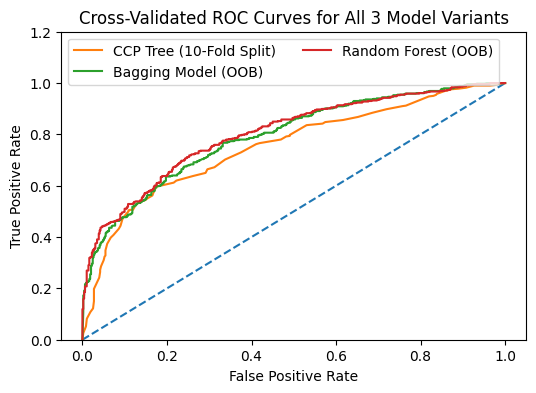

In [114]:
oob_bag_prob = [row[1] for row in bagger.oob_decision_function_]
oob_rf_prob = [row[1] for row in best_rf.model.oob_decision_function_]

oob_bag_auc = roc_auc_score(y_train, oob_bag_prob)
oob_rf_auc = roc_auc_score(y_train, oob_rf_prob)

print("OOB Bagging ROC-AUC:", oob_bag_auc)
print("OOB Random Forest ROC-AUC:", oob_rf_auc)

fpr_bag_o, tpr_bag_o = roc_curve(y_train, oob_bag_prob,
                                 pos_label="Yes")[:2]
fpr_rf_o, tpr_rf_o = roc_curve(y_train, oob_rf_prob,
                               pos_label="Yes")[:2]
fig, ax = subplots(figsize=(6,4))
ax.plot([0,1], [0,1], linestyle='--')
ax.plot(fpr_ccp_cv, tpr_ccp_cv, label="CCP Tree (10-Fold Split)")
ax.plot(fpr_bag_o, tpr_bag_o, label="Bagging Model (OOB)")
ax.plot(fpr_rf_o, tpr_rf_o, label="Random Forest (OOB)")
ax.set_ylabel("True Positive Rate")
ax.set_xlabel("False Positive Rate")
ax.set_title("Cross-Validated ROC Curves for All 3 Model Variants")
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0, 1.2)
fig.savefig("fig21.png")

plt.show()

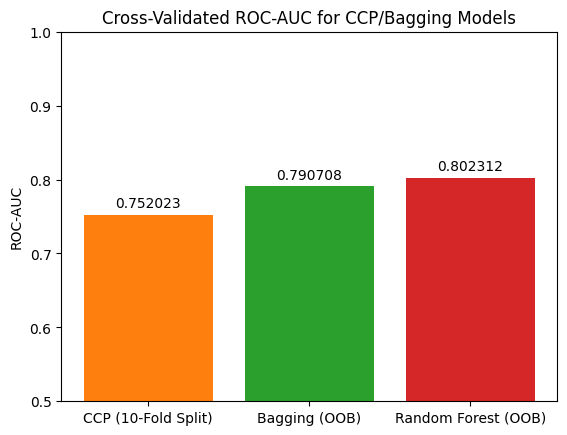

In [115]:
model_names_cv = ["CCP (10-Fold Split)", "Bagging (OOB)", "Random Forest (OOB)"]
aucs_cv = [ccp_kf_auc, oob_bag_auc, oob_rf_auc]
colors = ['tab:orange', 'tab:green', 'tab:red']

fig, ax = plt.subplots()

ax.bar_label(ax.bar(model_names_cv, aucs_cv, color=colors), padding=3)
ax.set_ylabel('ROC-AUC')
ax.set_title('Cross-Validated ROC-AUC for CCP/Bagging Models')
ax.set_ylim(0.5, 1)
fig.savefig("fig22.png")

plt.show()

# ROC-AUC for Random Forest on Training/Test Set

Training ROC-AUC: 0.9999999999999999
Test ROC-AUC: 0.8078666666666667


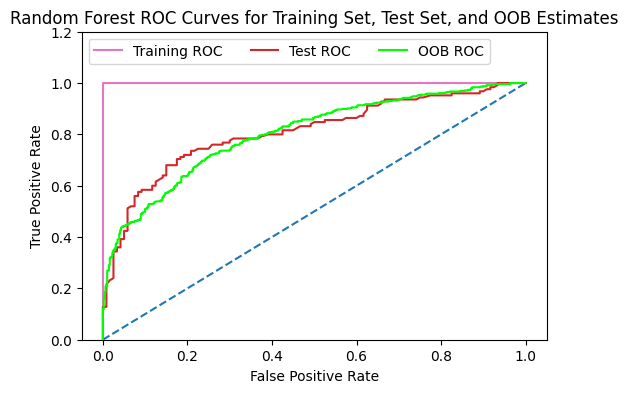

In [124]:
rf_prob_train = best_rf.model.predict_proba(X_train)[:,1]
rf_prob_test = best_rf.prob_test

auc_rf_train = roc_auc_score(y_train, best_rf.model.predict_proba(X_train)[:,1])
auc_rf_test = best_rf.auc

print("Training ROC-AUC:", auc_rf_train)
print("Test ROC-AUC:", auc_rf_test)

fpr_rf_train, tpr_rf_train = roc_curve(y_train, rf_prob_train,
                                       pos_label="Yes")[:2]
fpr_rf_test, tpr_rf_test = roc_curve(y_test, rf_prob_test,
                                     pos_label="Yes")[:2]
fig, ax = subplots(figsize=(6,4))
ax.plot([0,1], [0,1], linestyle='--')
ax.plot(fpr_rf_train, tpr_rf_train, label="Training ROC", color='tab:pink')
ax.plot(fpr_rf_test, tpr_rf_test, label="Test ROC", color='tab:red')
ax.plot(fpr_rf_o, tpr_rf_o, label="OOB ROC", color='lime')
ax.set_ylabel("True Positive Rate")
ax.set_xlabel("False Positive Rate")
ax.set_title("Random Forest ROC Curves for Training Set, Test Set, and OOB Estimates")
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1.2)
fig.savefig("fig23.png")

plt.show()

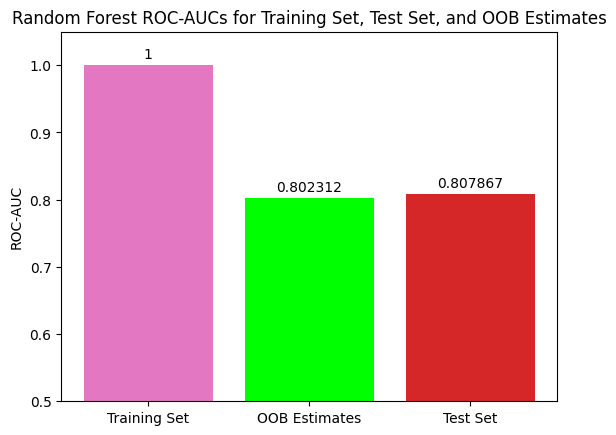

In [129]:
rf_auc_names = ["Training Set", "OOB Estimates", "Test Set"]
aucs_rf = [auc_rf_train, oob_rf_auc, auc_rf_test]
colors = ['tab:pink', 'lime', 'tab:red']

fig, ax = plt.subplots()

ax.bar_label(ax.bar(rf_auc_names, aucs_rf, color=colors), padding=3)
ax.set_ylabel('ROC-AUC')
ax.set_title('Random Forest ROC-AUCs for Training Set, Test Set, and OOB Estimates')
ax.set_ylim(0.5, 1.05)
fig.savefig("fig27.png")

plt.show()